# Stacked Autoencoder

In [ ]:
import collections
from collections import Counter
from collections import OrderedDict
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pyedflib
import pywt
import random
import re
from scipy import signal
from sklearn import metrics
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

# Preprocessing

# Unsupervised

## Convert Data Unsupervised

Download the dataset

In [ ]:
def randomly_split_records(dataset_stats):
  np.random.seed(1000)
  
  n_train = round(0.60 * len(dataset_stats))
  n_val = round(0.80 * len(dataset_stats))
  random.shuffle(dataset_stats)
  return dataset_stats[:n_train], dataset_stats[n_train:n_val], dataset_stats[n_val:]

In [ ]:
def get_dataset_stats(chb):
  np.random.seed(1000)

  dataset_root = fr"C:\Users\assaa\Documents\ECE496\Datasets\chb-mit-scalp-eeg-database-1.0.0\chb-mit-scalp-eeg-database-1.0.0\chb{chb:02}"
  summary_list = []

  for root, dir, files in os.walk(dataset_root, topdown=False):
    for name in files:
      if re.search(r'-summary.txt', name):
        summary_list.append((root, os.path.join(root, name)))


  train_seizure_records = []
  train_interictal_records = []
  test_seizure_records = []
  test_interictal_records = []
  val_seizure_records = []
  val_interictal_records = []

  for root, summary_path in summary_list:
    if (root[-5:] == "chb24"):
      break
    
    summary_text = open(summary_path, "r").read()
    parsed_summary = re.split("\n\n", summary_text)[2:]
    seizure_numbers = re.findall(r'Number of Seizures in File: (.)', summary_text)
    max_seizures_file = max([int(x) for x in seizure_numbers])

    # print(parsed_summary)

    seizure_records = []
    interictal_records = []

    for summary in parsed_summary:
      file_name = re.search(r'File Name: (.*?)\n', summary)
      if file_name:
        file_name = os.path.join(root, file_name.group(1))
        seizure_durations = []

        num_seizures = re.search(r'Number of Seizures in File: (.)', summary).group(1)
        num_seizures =  int(num_seizures)
        
        if(num_seizures > 0):
          if max_seizures_file < 2:
            seizure_start_time = re.search(r'Seizure Start Time: (.*?) seconds\n', summary)
            seizure_end_time = re.search('Seizure End Time: (.*?) seconds', summary)
            if seizure_start_time:
              seizure_start_time = int(seizure_start_time.group(1)) * 256
              seizure_end_time = int(seizure_end_time.group(1)) * 256
              seizure_durations.append((seizure_start_time, seizure_end_time))
            else:
              seizure_start_time = int(re.search(r'Seizure 1 Start Time: (.*?) seconds\n', summary).group(1)) * 256
              seizure_end_time = int(re.search('Seizure 1 End Time: (.*?) seconds', summary).group(1)) * 256
              seizure_durations.append((seizure_start_time, seizure_end_time))
          else:
            for i in range(num_seizures):
              seizure_num = i + 1
              seizure_start_time = re.search(r'Seizure %i Start Time: (.*?) seconds\n'%(seizure_num), summary)
              seizure_end_time = re.search('Seizure %i End Time: (.*?) seconds'%(seizure_num), summary)
              if seizure_start_time:
                seizure_start_time = int(seizure_start_time.group(1)) * 256
                seizure_end_time = int(seizure_end_time.group(1)) * 256
                seizure_durations.append((seizure_start_time, seizure_end_time))
              else:
                seizure_start_time = int(re.search(r'Seizure Start Time: (.*?) seconds\n', summary).group(1)) * 256
                seizure_end_time = int(re.search('Seizure End Time: (.*?) seconds', summary).group(1)) * 256
                seizure_durations.append((seizure_start_time, seizure_end_time))
          seizure_records.append([file_name, num_seizures, seizure_durations])
        else:
          interictal_records.append([file_name, num_seizures, seizure_durations])

    random.shuffle(seizure_records)
    random.shuffle(interictal_records)

    train_s, val_s, test_s = randomly_split_records(seizure_records)
    train_i, val_i, test_i = randomly_split_records(interictal_records)

    train_seizure_records += train_s
    val_seizure_records += val_s
    test_seizure_records += test_s
    train_interictal_records += train_i
    val_interictal_records += val_i
    test_interictal_records += test_i

  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)

In [ ]:
#Old functions, no longer used.

def load_train_seizure_data(stats):
  file_paths = stats[:,0]
  ictal_segments = []

  for index, path in enumerate(file_paths):
    f = pyedflib.EdfReader(path)
    n = f.signals_in_file
    for i in range(n):
      signal = f.readSignal(i, digital=True)
      num_segments = math.ceil(len(signal) / 1280) * 10

      for duration in stats[index][2]:
        start = math.ceil(duration[0] / 5)
        end = math.floor(duration[1] / 5)

        ictal_segments += [(path, i, num_segments, x, 1) for x in range(start, end + 1)]
    f.close()
  return ictal_segments

def load_train_interictal_data(stats):
  interictal_stats = []

  for path in stats:
    f = pyedflib.EdfReader(path)
    n = f.signals_in_file
    for i in range(n):
      signal = f.readSignal(i, digital=True)
      num_segments = math.ceil(len(signal) / 1280) * 10
      interictal_stats += [(path, i, num_segments, x, 0) for x in range(num_segments)]
    f.close()
  return interictal_stats

In [ ]:
#Determine if the segment lies within a seizure interval.
def is_abnormal(index, seg_size, durations):
  for duration in durations:
    seizure_start = duration[0]
    seizure_end = duration[1]
    seg_start = index
    seg_end = index + seg_size

    if seizure_start <= seg_start <= seizure_end or seg_start <= seizure_start <= seg_end:
      return True

  return False

#Get the segments for the signal.
def segment(signal, durations, is_seizure_record):
    seg_size = 1280 # 5 Seconds
    overlap = 0.1 # 90% overlap
    index = 0
    segments = []
    # labels = []

    need_last_seg = True

    while index <= len(signal) - 1280:
      if index + seg_size == len(signal) - 1:
        need_last_seg = False

      # Add labels for each segment
        # 0 - Normal
        # 1 - Abnormal
      if is_abnormal(index, seg_size, durations) and is_seizure_record:
        segment = signal[index:index + seg_size]
        segments.append((segment, 1))
      elif not is_seizure_record:
        segment = signal[index:index + seg_size]
        segments.append((segment, 0))

      index += math.ceil(overlap * seg_size)

    if need_last_seg:
      
      if is_abnormal(len(signal) - 1 - seg_size, seg_size, durations) and is_seizure_record:
        segment = signal[-seg_size:]
        segments.append((segment, 1))
      elif not is_seizure_record:
        segment = signal[-seg_size:]
        segments.append((segment, 0))

    return segments

#Load the data for the specified file(s).
def load_data(stats, is_seizure_record):
  file_names = stats[:,0]
  dataset = []
  seg_size = 1280

  X_data = []

  #Loop through the records.
  for index, name in enumerate(file_names):
    f = pyedflib.EdfReader(name)
    n = f.signals_in_file
    #Loop through the signals.
    for i in range(n):
      #Return the segments into a list.
      signal = f.readSignal(i, digital=True)
      segments = segment(signal, stats[index][2], is_seizure_record)
      X_data += segments
    f.close()
    # dataset += [(name, X_data, Y_data, stats[index][2]))
  return X_data

# dataset = load_data(dataset_stats)

In [ ]:
#Under sample the data set.
def under_sample_new(stats, number):
  print("Executing under sampling")
  records = load_data(stats, False)
  print(len(records))
  records = random.sample(records, number)
  print(len(records))
  return list(records)

In [ ]:
# train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats()

# # train_records = np.concatenate((train_seizure_records, train_interictal_records))
# # val_records = np.concatenate((val_seizure_records, val_interictal_records))

# if len(val_seizure_records) != 0:
#   train_seizure_records_plus_val = np.concatenate((train_seizure_records, val_seizure_records))
# else:
#   train_seizure_records_plus_val = train_seizure_records
#   val_seizure_records = np.array([train_seizure_records[0].tolist()])

# # train_plus_val_records = np.concatenate((train_records, val_records))

# train_interictal_records_plus_val = np.concatenate((train_interictal_records, val_interictal_records))

TypeError: ignored

Download the dataset

In [ ]:
# #Training and validation data put together for the unsupervised stage.

# X_data = load_data(train_seizure_records_plus_val, True)
# # print(len(X_data))
# X_data += under_sample_new(train_interictal_records_plus_val, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# print(X_data)
# X_train_all = X_data[:,0]



# # #Training and validation data separated for the supervised stage.

# X_data = load_data(train_seizure_records, True)
# X_data += under_sample_new(train_interictal_records, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_train = X_data[:,0]
# Y_train = X_data[:,1]

# X_data = load_data(val_seizure_records, True)
# X_data += under_sample_new(val_interictal_records, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_val = X_data[:,0]
# Y_val = X_data[:,1]

Executing under sampling
4493648
1242
[[array([79, 77, 86, ..., 47, 41, 27]) 1]
 [array([-390, -702, -494, ...,   66,   42,   68]) 0]
 [array([ 6, 18, 22, ..., 59, 25, 11]) 1]
 ...
 [array([  3,   0,   4, ..., 204, 158, 133]) 0]
 [array([-121, -153, -120, ..., -110,  -43,   38]) 1]
 [array([155, 158, 169, ...,  77,  88,  91]) 1]]


C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\1465650279.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
3335736
805


C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\1465650279.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
1157912
437


C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\1465650279.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


In [ ]:
X_data=np.asarray(X_data)

C:\Users\assaa\AppData\Local\Temp\ipykernel_33408\41022765.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data=np.asarray(X_data)


In [ ]:
print(X_data[:,0])

[array([-209, -211, -225, ...,   34,   27,   25])
 array([ 97, 101,  88, ..., 386, 396, 385])
 array([-120, -127, -146, ...,   85,   97,   94]) ...
 array([ 85,  76,  74, ..., -66, -72, -67])
 array([55, 42, 38, ..., 66, 66, 62]) array([40, 36, 45, ..., 36, 16,  1])]


In [ ]:
print(X_data)

[(array([-209, -211, -225, ...,   34,   27,   25]), 1), (array([ 97, 101,  88, ..., 386, 396, 385]), 1), (array([-120, -127, -146, ...,   85,   97,   94]), 1), (array([ 31,  45,  41, ..., -11,  -1,   0]), 1), (array([  49,   31,   -6, ..., -157, -184, -221]), 1), (array([ 231,  246,  250, ...,  -54,  -91, -130]), 1), (array([59, 79, 89, ..., 11, 16, 12]), 1), (array([-179, -173, -182, ...,  -54,  -43,  -39]), 1), (array([180, 179, 166, ...,  39,  48,  41]), 1), (array([  7,  19,  16, ..., -46, -40, -49]), 1), (array([-30, -39, -33, ..., -52, -44, -34]), 1), (array([141, 124, 129, ...,  83,  87,  90]), 1), (array([-124, -123,  -99, ...,  -89,  -96,  -96]), 1), (array([-70, -75, -61, ..., 110, 113, 124]), 1), (array([-27, -62, -68, ...,  82,  80,  78]), 1), (array([-187, -203, -187, ...,    0,  -26,  -39]), 1), (array([ 194,  193,  193, ..., -117, -108,  -89]), 1), (array([-117, -141, -133, ...,  215,  234,  260]), 1), (array([55, 41, 39, ..., 53, 47, 49]), 1), (array([ 76,  65,  76, ...

In [ ]:
print(len(X_data))

2484


In [ ]:
X_data

array([[432, 0],
       [array([ -17,  -20,  -26, ..., -102, -108, -104]), 1],
       [663, 0],
       ...,
       [array([212, 212, 201, ..., 213, 216, 226]), 1],
       [array([-98, -93, -88, ..., -51, -70, -76]), 1],
       [496, 0]], dtype=object)

In [ ]:
print(len(X_data))

943


In [ ]:
# #Training and validation data put together for the unsupervised stage.

# X_data = load_train_seizure_data(train_seizure_records_plus_val)
# X_data += under_sample_new(train_interictal_records_plus_val, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_train_all = X_data[:,:4]



# #Training and validation data separated for the supervised stage.

# X_data = load_train_seizure_data(train_seizure_records)
# X_data += under_sample_new(train_interictal_records, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_train = X_data[:,:4]
# Y_train = X_data[:,4]

# X_data = load_train_seizure_data(val_seizure_records)
# X_data += under_sample_new(val_interictal_records, len(X_data))
# random.shuffle(X_data)
# X_data = np.asarray(X_data)
# X_val = X_data[:,:4]
# Y_val = X_data[:,4]

7727770
1127
6188610
1127
1539160
460


## CWT to generate scalograms for time-frequency representation, i.e. 2D-CNN

In [ ]:
#Same as get_cwt() but sample is formatted differently.
def get_cwt_features(sample):
    f = pyedflib.EdfReader(sample[0])
    n = f.signals_in_file

    chn = int(sample[1])
    num_segments = int(sample[2])
    index = int(sample[3])

    signal = f.readSignal(chn, digital=True)
    segments = np.array_split(signal, num_segments)

    coef, _ =pywt.cwt(segments[index], np.arange(2,67),'morl', sampling_period=0.00390625) # Primary paper followed used Morelet mother wave
    coef.resize((22, 1280)) 
    f.close()
    return coef

#Apply CWT on the signal segment.
def get_cwt(segment):
    coef, _ =pywt.cwt(segment, np.arange(2,67),'morl', sampling_period=0.00390625) # Primary paper followed used Morelet mother wave
    coef.resize((22, 1280)) 
    return coef

* label EEG segments
* segment the EEG segments
* use CWT to generate scalograms
* split scalograms into testing/train for input and output sets

* 289 : number of segments
* 21 : range of sizes embedded into the CWT
* 1279 : number of samples 

## Stacked Autoencoder Model

Loading state to model with new layers: 

https://stackoverflow.com/questions/70986805/how-to-save-and-load-only-particular-layers-of-a-neural-network-with-pytorch

https://pytorch.org/tutorials/beginner/saving_loading_models.html


## Training

In [ ]:
#Stacked autoencoder including the decoder layers.
class StackedAutoencoder(nn.Module):
    def __init__(self):
        super(StackedAutoencoder, self).__init__() 
        self.name = "Autoencoder"
        self.encoder1 = nn.Conv2d(1, 2, 3, 1)   # in_channels, out_channels, kernal_size, stride
        self.encoder2 = nn.Conv2d(2, 4, 3, 1)

        self.decoder1 = nn.ConvTranspose2d(4, 2, 3, 1)
        self.decoder2 = nn.ConvTranspose2d(2, 1, 3, 1)

        self.pool = nn.MaxPool2d(2, stride=1, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, stride=1)
        
    def forward(self, x):
        x = F.relu(self.encoder1(x))
        size1 = x.size()
        x, idx1 = self.pool(x)
        
        x = F.relu(self.encoder2(x))
        size2 = x.size()
        x, idx2 = self.pool(x)
        
        x = self.unpool(x, idx2, size2)
        x = F.relu(self.decoder1(x))

        x = self.unpool(x, idx1, size1)
        x = F.relu(self.decoder2(x))
        
        return x

In [ ]:
def load_data_train(stats, func):
  X_data, Y_data = load_data(stats, func)
  X_data, Y_data = under_sample(np.array(list(zip(X_data, Y_data))))
  return np.asarray(X_data), np.asarray(Y_data)

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

#Unsupervised training stage.
def train_net(net, chb, X_train_all, batch_size=24, learning_rate=0.01, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Define the Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    #This will store the loss average for each epoch.
    losses = np.zeros(num_epochs)
    # count = 0
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_loss = 0.0
        count = 0

        train_indices = np.arange(len(X_train_all)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train_all.shape[0], batch_size):
            batch = train_indices[it:(it + batch_size)]
            X = [[get_cwt(x)] for x in X_train_all[batch]]
            X = np.array(X)
            X = torch.Tensor(X)
            X = X.cuda()

            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(X)
            loss = criterion(outputs, X)
            loss.backward()
            optimizer.step()

            #Add to the total loss for this epoch.
            total_loss += loss.item()
            count += 1
            print("Batch ", count, " complete.")
            
        losses[epoch] = float(total_loss) / (count)

        print()
        print("EPOCH: ", epoch+1, " LOSS: ", losses[epoch])
        print()

    plt.title("Training Loss Curve")
    plt.plot(range(1,len(losses)+1), losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.savefig(fr'C:\Users\assaa\Documents\ECE496\Testing\TrainingPlots\unsupervised_chb{chb:02}.png')
    plt.show()

    print(epoch, "Final Training Loss: {}".format(losses[-1]))

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_min = elapsed_time / 60
    print("Total time elapsed: {:.2f} minutes".format(time_min))

In [ ]:
#Run this to close all the files
# for i in range(10):
for root, dir, files in os.walk(dataset_root, topdown=False):
  # print(dir)
  for f in files:
      if f[-3:] == "edf":
        fd = open(os.path.join(root, f))
        fd.close()

        # if fd.closed:
        #   print(f, "is closed")

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
Batch  48  complete.
B

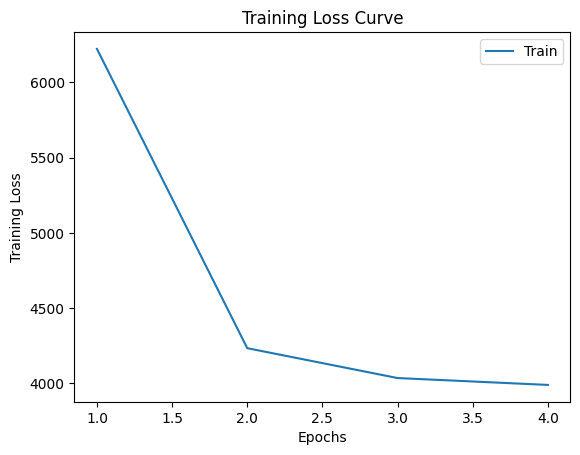

3 Final Training Loss: 3990.46977351262
Finished Training
Total time elapsed: 1.39 minutes


<Figure size 640x480 with 0 Axes>

In [ ]:
autoencoder = StackedAutoencoder()
autoencoder.cuda()

train_net(autoencoder, 1, X_train_all, batch_size=32, learning_rate=0.01, num_epochs=4)

In [ ]:
# torch.save(autoencoder.state_dict(), r"C:\Users\assaa\Documents\ECE496\Models\autoencoderfinal_32bs_2epochs.pth")

# Supervised

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Convert Data Supervised

## Classifier Model

In [ ]:
# autoencoder = StackedAutoencoder()
# autoencoder.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\autoencoderfinal_32bs_2epochs.pth"))

<All keys matched successfully>

Now that we have finished the unsupervised training stage of the stacked autoencoder, we need to freeze the weights of its encoder layers for the next stage which is replacing the decoder layers with a classifier and fine tuning it using supervised training.

In [ ]:
# #Save the weights and biases for the encoder layers, but not the decoder
# #layers.


# #Store the parameters of each layer in the stacked autoencoder.
# stacked_state = autoencoder.state_dict()

# #Initialize an empty ordered dictionary for the new classifier model.
# classifier_state = OrderedDict()

# #Loop through each encoder parameter and save it in the new dictionary.
# for param in stacked_state:
#   if "encoder" in param:
#     classifier_state[param] = stacked_state[param]

In [ ]:
#Same architecture as before but decoder layers are replaced with a linear
#layer.
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__() 
        self.name = "CNN"
        
        self.encoder1 = nn.Conv2d(1, 2, 3, 1)   # in_channels, out_channels, kernal_size, stride
        self.encoder2 = nn.Conv2d(2, 4, 3, 1)

        self.pool = nn.MaxPool2d(2, stride=1)

        self.fc = nn.Linear (4 * 16 * 1274, 2)
        
    def forward(self, x):

        x = F.relu(self.encoder1(x))
        x = self.pool(x)
        
        x = F.relu(self.encoder2(x))
        x = self.pool(x)
        
        x = x.view(-1, 4 * 16 * 1274)
        x = self.fc(x)

        return x

In [ ]:
# #Load the previously freezed parameters into the new classifier model.

# #Create a new model and save its inital weights.
# classifier = Classifier()
# classifier_init_state = classifier.state_dict()

# #Replace the encoder weights with the ones acquired during training.
# for param in classifier_init_state:
#   if param not in classifier_state:
#     classifier_state[param] = classifier_init_state[param]

# #Save the new state in the classifier model.
# classifier.load_state_dict(classifier_state)

<All keys matched successfully>

In [ ]:
#Supervised training stage.
def train_classifier(net, chb, X_train, X_val, Y_train, Y_val, batch_size=24, learning_rate=0.01, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the training/acurracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    val_accs = []
    train_accs = []
    iters = []
    iterations = 0
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        train_acc = 0      # training accuracy per batch
        pred = 0
        corr = 0
        tot = 0
        
        val_acc = 0        # validation accuracy per batch
        pred_val = 0
        corr_val = 0
        tot_val = 0

        count = 0
        
        # Training dataset
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], batch_size):
            batch = train_indices[it:(it + batch_size)]
            X = torch.Tensor(np.array([[get_cwt(x)] for x in X_train[batch]]))
            X = X.cuda()
            Y = torch.Tensor(Y_train[batch].astype(np.int32))
            Y = Y.cuda()
            
            # print(inputs)

            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(X)
            loss = criterion(outputs, Y.long())
            loss.backward()
            optimizer.step()

            # get training accuracy
            pred = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
            corr += pred.eq(Y.view_as(pred)).sum().item()
            tot += Y.shape[0]

            count += 1
            print("Batch ", count, " complete.")
        # training accuracy
        train_acc = corr / tot

        # Validation dataset
        print("Validating...")

        val_indices = np.arange(len(X_val)) 
        np.random.shuffle(val_indices)
        for it in range(0, X_val.shape[0], batch_size):
            batch = val_indices[it:(it + batch_size)]
            X = torch.Tensor(np.array([[get_cwt(x)] for x in X_val[batch]]))
            X = X.cuda()
            Y = torch.Tensor(Y_train[batch].astype(np.int32))
            Y = Y.cuda()
            
            outputs = net(X)
            pred_val = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
            corr_val += pred_val.eq(Y.view_as(pred_val)).sum().item()
            tot_val += Y.shape[0]
        # validation accuracy
        val_acc = corr_val / tot_val

        print("Epoch ", epoch+1, " - Train: ", train_acc, "Val: ", val_acc)
        print()
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        iters.append(iterations)
        
        
    plt.title("Accuracy Curve")
    plt.plot(range(1,len(train_accs)+1), train_accs, label="Train")
    plt.plot(range(1,len(val_accs)+1), val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig(fr'C:\Users\assaa\Documents\ECE496\Testing\TrainingPlots\supervised_chb{chb:02}.png')
    plt.show()

    print("Final Training Accuracy: {}".format(train_accs[-1]))
    print("Final Validation Accuracy: {}".format(val_accs[-1]))
    
    print()
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_min = elapsed_time / 60
    print("Total time elapsed: {:.2f} minutes".format(time_min))

In [ ]:
#Run this to close all the files
# for i in range(10):
for root, dir, files in os.walk(dataset_root, topdown=False):
  # print(dir)
  for f in files:
      if f[-3:] == "edf":
        fd = open(os.path.join(root, f))
        fd.close()

        # if fd.closed:
        #   print(f, "is closed")

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
Batch  48  complete.
B

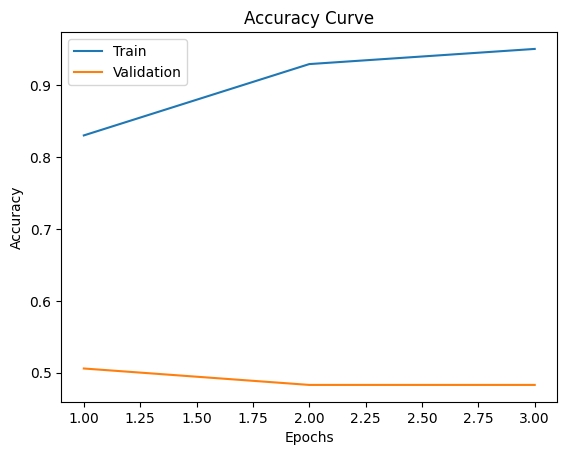

Final Training Accuracy: 0.9509316770186336
Final Validation Accuracy: 0.482837528604119

Total time elapsed: 1.01 minutes


<Figure size 640x480 with 0 Axes>

In [ ]:
# cnn_model = CNN()
# classifier = Classifier()
classifier.cuda()

train_classifier(classifier, 1, X_train, X_val, Y_train, Y_val, batch_size=32, learning_rate=0.01, num_epochs=3)

In [ ]:
torch.save(classifier.state_dict(), r"C:\Users\assaa\Documents\ECE496\Models\classifier_chb"+chb+"_32bs_2epochs_v2.pth")

In [ ]:
classifier = Classifier()
classifier.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\classifier_chb01_32bs_2epochs_v2.pth"))

<All keys matched successfully>

# Validation Methods

In [ ]:
#This version of segment() returns all seizure segments but also returns
#all non-seizure segments after each seizure interval up to the number
#of segments in that interval. This way there is a 50:50 split between
#seizure and non-seizure segments.
def segment_test(signal, durations):
    seg_size = 1280 # 5 Seconds
    overlap = 0.1 # 90% overlap
    index = 0
    segments = []
    # labels = []

    # need_last_seg = True

    num_seizure_durations = len(durations)
    seizure_duration_count = 0
    num_seizures = 0
    num_interictal = 0

    while index <= len(signal) - 1280:
      # if index + seg_size == len(signal) - 1:
      #   need_last_seg = False

      
      # print("segment called")
      # Add labels for each segment
        # 0 - Normal
        # 1 - Abnormal
      # for duration in durations:
      if is_abnormal(index, seg_size, durations):
        segment = signal[index:index + seg_size]
        segments.append((segment, 1))
        num_seizures += 1
      else:
        if num_interictal < num_seizures and num_seizures > 0:
          segment = signal[index:index + seg_size]
          segments.append((segment, 0))
          num_interictal += 1
        else:
          if num_seizures > 0:
            seizure_duration_count += 1
            if seizure_duration_count == num_seizure_durations:
              break

          num_seizures = 0
          num_interictal = 0

      index += math.ceil(overlap * seg_size)

    # if need_last_seg:
      
    #   if is_abnormal(len(signal) - 1 - seg_size, seg_size, durations):
    #     segment = signal[-seg_size:]
    #     segments.append((segment, 1))
    #   else:
    #     segment = signal[-seg_size:]
    #     segments.append((segment, 0))

    #return segments array and take a few and convert into scalograms during
    #training

    return segments

In [ ]:
#Load the test data for the record file.
def load_test_data(stat):
  record_arr = []
  label_arr = []

  X_data = []

  f_path = stat[0]
  seizure_durations = stat[2]

  f = pyedflib.EdfReader(f_path)
  n = f.signals_in_file
  for i in range(n):
    signal = f.readSignal(i, digital=True)
    segments = segment_test(signal, stat[2])
    X_data += segments
  f.close()
  return X_data

In [ ]:
#This function is the same as label_record() but without irrelevant
#operations to acquiring sampling speed, such as comparing predictions.
#Also it takes timestamps and records number of samples per segment to
#get the labelling speed.
def label_record_speed(net, record, load_func, batch_size=1):
  # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    start_time = time.time()

    test_data = load_func(record)

    test_data = np.asarray(test_data)

    segment_arr = test_data[:,0]

    seizure_durations = record[2]

    pred = 0
    total_samples = 0

    #Testing
    train_indices = np.arange(len(segment_arr))
    for it in range(0, segment_arr.shape[0], batch_size):
      batch = train_indices[it:(it + batch_size)]
      X_test = torch.Tensor(np.array([[get_cwt(x)] for x in segment_arr[batch]]))
      # print("New batch")
      # print(len(segment_arr[batch][0]))
      X_test = X_test.cuda()
      total_samples += len(segment_arr[batch][0])

      outputs = net(X_test)
      pred = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    rate = total_samples / elapsed_time

    # with open(r'C:\Users\assaa\Documents\ECE496\test_results.txt', 'w') as sys.stdout:
    print("Record: ", record)
    print("Speed: ", rate)
    
    return rate

In [ ]:
#Return the labelling rate of the model.
def test_speed(net, test_records, save_file, load_func):
  total_rates = 0
  num_records = 0

  
  for record in test_records:
    net.cuda()
    rate = label_record_speed(net, record, load_func)
    num_records += 1
    total_rates += rate
  
  #Average rate.
  total_rates /= num_records

  print("\nAverage speed: " + str(total_rates))

  test_f = open(save_file, "a")
  test_f.write("Average speed: " + str(total_rates) + "\n")
  test_f.close()
  # return total_rates

In [ ]:
def get_overlap(start_1, end_1, start_2, end_2):
  return range(max(start_1, start_2), min(end_1, end_2))

def is_overlaping(start_1, end_1, start_2, end_2):
  if len(get_overlap(start_1, end_1, start_2, end_2)):
    return True
  return False

#Predicted seizure intervals.
def calculate_seziure_times(labels, tolerance=5):
  start = None
  count = 0
  seizures = []
  for (index, label) in enumerate(labels):
    if label:
      if not start:
        start = index * 128
    else:
      if start:
        count += 1
        if count == tolerance:
          seizures.append((start, index * 128))
          start = None
          count = 0
  return seizures

#Calculate the latency measurement.
def calculate_latency(seizure_durations, seizure_times):
  count = 0
  S = len(seizure_durations)
  latency = 0

  if S == 0:
    return -1

  for (seizure_start, seizure_end) in seizure_durations:
    for (start, end) in seizure_times:
      overlap = get_overlap(seizure_start, seizure_end, start, end)
      if len(overlap):
        latency += (overlap[0] - seizure_start) / 256
        count += 1
        break

  if count == 0:
    return -1

  return latency / count

#Calculate sensitivity.
def calculate_sensitivity(seizure_durations, seizure_times):
  count = 0
  S = len(seizure_durations)

  if S == 0:
    return -1

  if len(seizure_times) == 0:
    return -1
  
  for (seizure_start, seizure_end) in seizure_durations:
    detected = False
    for (start, end) in seizure_times:
      if is_overlaping(seizure_start, seizure_end, start, end):
        count += 1
        break
  return count / S

#Calculate FPR.
def calculate_false_pos_rate(Y_test, Y_pred):
  count = 0
  N = len([label for label in Y_test if label == 0])

  for i in range(len(Y_pred)):
    if Y_pred[i] and not Y_test[i]:
      count += 1

  return 3600 * 256 * (count / N)

In [ ]:
def evaluate(model, record, load_func, batch_size=32):

  test_data = load_func(record)
  test_data = np.asarray(test_data)

  segment_arr = test_data[:,0]
  true_label_arr = test_data[:,1]

  idx = 0

  seizure_durations = record[2]

  predictions = []

  #Testing
  train_indices = np.arange(len(segment_arr))
  for it in range(0, segment_arr.shape[0], batch_size):
    batch = train_indices[it:(it + batch_size)]
    X_test = torch.Tensor(np.array([[get_cwt(x)] for x in segment_arr[batch]]))
    X_test = X_test.cuda()


    Y_test = true_label_arr[batch].tolist()

    outputs = model(X_test)
    # print(outputs)
    pred = outputs.max(1, keepdim=True)[1] # select index with maximum prediction score
    pred_list = pred.cpu().squeeze().tolist()
    predictions += pred_list

    for i in range(len(pred_list)):
      
      # if idx <= 17582:
      #   idx += 1
      #   continue

      #Save the scalogram image and saliency map for each segment.

      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      model = model.to(device)

      scalogram = X_test[i]
      scalogram.reshape(1, 1, 220, 128)
      scalogram = scalogram.to(device)
      scalogram.requires_grad_()

      # Retrieve output from the image
      output = model(scalogram)


      if Y_test[i]:
        truth_str = "Seizure"
      else:
        truth_str = "Non-seizure"
      if pred_list[i]:
        pred_str = "Seizure"
      else:
        pred_str = "Non-seizure"


      pred = output.max(1, keepdim=True)[1]
      title = "Truth: " + truth_str + "\nPrediction: " + pred_str


      output_idx = output.argmax()
      output_max = output[0, output_idx]


      output_max.backward()

      saliency = scalogram.grad.data.abs()
      saliency = saliency.reshape(220, 128)

      scalogram = scalogram.reshape(-1, 220, 128)

      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(scalogram.cpu().detach().numpy().transpose(1, 2, 0))
      ax[0].axis('off')
      ax[1].imshow(saliency.cpu(), cmap='hot')
      ax[1].axis('off')
      fig.suptitle(title)

      #Save to the folder based on if it is FP, FN, TP, or TN.
      if pred_list[i] and not Y_test[i]:
        fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\Autoencoder\FalsePositive\segment' + str(idx) + '.png')
      elif not pred_list[i] and Y_test[i]:
        fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\Autoencoder\FalseNegative\segment' + str(idx) + '.png')
      elif pred_list[i] and Y_test[i]:
        fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\Autoencoder\TruePositive\segment' + str(idx) + '.png')
      elif not pred_list[i] and not Y_test[i]:
        fig.savefig(r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\Autoencoder\TrueNegative\segment' + str(idx) + '.png')
      
      # plt.show()

      idx += 1

  #Calculate and return seizure times.
  seizure_times = calculate_seziure_times(predictions)

  # Evaluation Metrics
  latency = calculate_latency(seizure_durations, seizure_times)
  sensitivity = calculate_sensitivity(seizure_durations, seizure_times)
  false_pos_rate = calculate_false_pos_rate(true_label_arr, predictions)

  print("Record: ", record)
  print("Latency: ", latency)
  print("Sensitivity: ", sensitivity)
  print("FPR: ", false_pos_rate)
  print()

  return latency, sensitivity, false_pos_rate

In [ ]:
#Run this to close all the files
# for i in range(10):
dataset_root = fr"C:\Users\assaa\Documents\ECE496\Datasets\chb-mit-scalp-eeg-database-1.0.0\chb-mit-scalp-eeg-database-1.0.0\chb02"
for root, dir, files in os.walk(dataset_root, topdown=False):
  # print(dir)
  for f in files:
      if f[-3:] == "edf":
        fd = open(os.path.join(root, f))
        fd.close()

        # if fd.closed:
        #   print(f, "is closed")

In [ ]:
#This function tests the latency, sensitivity, and false positive rate
#of the model.
def test_accuracy(net, test_records, save_file, load_func):
  total_latency = 0
  total_sensitivity = 0
  total_fpr = 0

  num_lat_records = 0
  num_sens_records = 0
  num_fpr_records = 0

  for record in test_records:
    print(record)
    net.cuda()
    
    #Return measurements for each record.
    lat, sens, fpr = evaluate(net, record, load_func)

    if lat != -1:
      total_latency += lat
      num_lat_records += 1
    
    if sens != -1:
      total_sensitivity += sens
      num_sens_records += 1

    total_fpr += fpr
    num_fpr_records += 1

  if num_lat_records == 0:
    total_latency = -1
  else:
    total_latency /= num_lat_records

  if num_sens_records == 0:
    total_sensitivity = -1
  else:
    total_sensitivity /= num_sens_records
  
  total_fpr /= num_fpr_records

  print("Average latency: " + str(total_latency))
  print("Average sensitivity: " + str(total_sensitivity))
  print("Average FPR: " + str(total_fpr))

  test_f = open(save_file, "a")
  test_f.write("Average latency: " + str(total_latency) + "\n")
  test_f.write("Average sensitivity: " + str(total_sensitivity) + "\n")
  test_f.write("Average FPR: " + str(total_fpr) + "\n")
  test_f.close()

  # return total_latency, total_sensitivity, total_fpr

In [ ]:
test_accuracy(classifier, test_interictal_records)

In [ ]:
test_accuracy(classifier, test_seizure_records)

In [ ]:
test_speed(classifier, test_seizure_records)

# Automated Training and Testing

In [ ]:
train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats(1)

C:\Users\assaa\AppData\Local\Temp\ipykernel_7268\2211526169.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)


In [ ]:
test_seizure_records

array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_04.edf',
        1, list([(375552, 382464)])]], dtype=object)

In [ ]:
test_data = load_test_data_all(test_seizure_records[0])
test_data = np.asarray(test_data)

C:\Users\assaa\AppData\Local\Temp\ipykernel_7268\3725139525.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


In [ ]:
print(len(test_data))

165416


In [ ]:
test_seizure_records[0]

array(['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_16.edf',
       1, list([(33280, 54272)])], dtype=object)

In [ ]:
test_data = load_test_data(test_seizure_records[0])
test_data = np.asarray(test_data)

C:\Users\assaa\AppData\Local\Temp\ipykernel_14084\3085946810.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


In [ ]:
print(len(test_data))

15456


In [ ]:
#old test data length
print(len(test_data))

165416


In [ ]:
if len(val_seizure_records) != 0:
  train_seizure_records_plus_val = np.concatenate((train_seizure_records, val_seizure_records))
else:
  train_seizure_records_plus_val = train_seizure_records
  val_seizure_records = np.array([train_seizure_records[0].tolist()])

# train_plus_val_records = np.concatenate((train_records, val_records))

train_interictal_records_plus_val = np.concatenate((train_interictal_records, val_interictal_records))

In [ ]:
X_data = load_data(train_seizure_records_plus_val, True)
# print(len(X_data))
X_data += under_sample_new(train_interictal_records_plus_val, len(X_data))
random.shuffle(X_data)
X_data = np.asarray(X_data)
X_train_all = X_data[:,0]

Executing under sampling
4450546
1265


C:\Users\assaa\AppData\Local\Temp\ipykernel_14084\1561302094.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


In [ ]:
#before duration time fix
print(len(X_train_all))

2530


In [ ]:
print(len(X_train_all))

40020


In [ ]:
def segment_test_all(signal, durations):
    seg_size = 1280 # 5 Seconds
    overlap = 0.1 # 90% overlap
    index = 0
    segments = []
    # labels = []

    need_last_seg = True

    while index <= len(signal) - 1280:
      if index + seg_size == len(signal) - 1:
        need_last_seg = False

      
      # print("segment called")
      # Add labels for each segment
        # 0 - Normal
        # 1 - Abnormal
      if is_abnormal(index, seg_size, durations):
        segment = signal[index:index + seg_size]
        segments.append((segment, 1))
      else:
        segment = signal[index:index + seg_size]
        segments.append((segment, 0))

      index += math.ceil(overlap * seg_size)

    if need_last_seg:
      
      if is_abnormal(len(signal) - 1 - seg_size, seg_size, durations):
        segment = signal[-seg_size:]
        segments.append((segment, 1))
      else:
        segment = signal[-seg_size:]
        segments.append((segment, 0))

    #return segments array and take a few and convert into scalograms during
    #training

    return segments

def load_test_data_all(stat):
  X_data = []

  f_path = stat[0]
  seizure_durations = stat[2]

  f = pyedflib.EdfReader(f_path)
  n = f.signals_in_file
  for i in range(n):
    signal = f.readSignal(i, digital=True)
    segments = segment_test_all(signal, stat[2])
    X_data += segments
  f.close()
  return X_data

RUNNING ON CHB02



C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\2211526169.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)
C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\4038019432.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_seizure_records = np.array([train_seizure_records[0].tolist()])


Executing under sampling
4300816
8004


C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\4038019432.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
3308320
8004


C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\4038019432.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Executing under sampling
992496
3979
Initiating Pre-Training



C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\4038019432.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.asarray(X_data)


Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  complete.
Batch  44  complete.
Batch  45  complete.
Batch  46  complete.
Batch  47  complete.
Batch  48  complete.
B

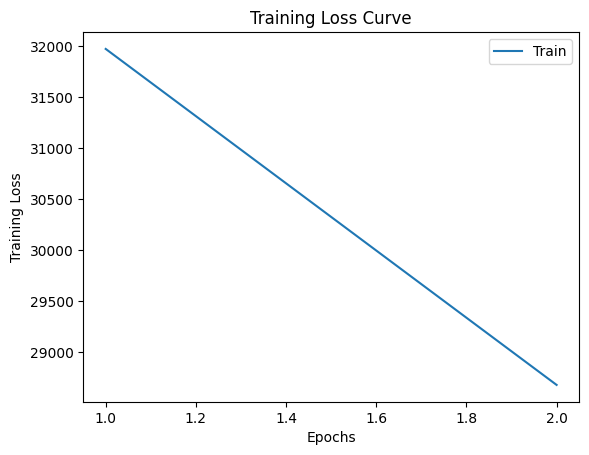

1 Final Training Loss: 28676.58896854728
Finished Training
Total time elapsed: 4.42 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

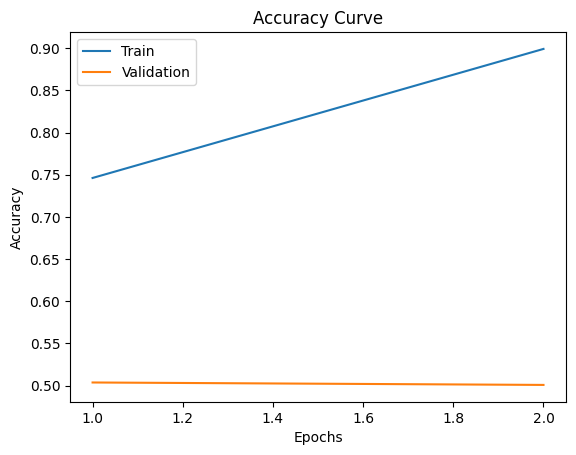

Final Training Accuracy: 0.8990504747626187
Final Validation Accuracy: 0.500879617994471

Total time elapsed: 6.45 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_19.edf'
 1 list([(862464, 864768)])]


C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\3827164105.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_19.edf'
 1 list([(862464, 864768)])]
Latency:  -1
Sensitivity:  0.0
FPR:  198966.11694152924

Average latency: -1
Average sensitivity: 0.0
Average FPR: 198966.11694152924
Seizure accuracy test complete.




C:\Users\assaa\AppData\Local\Temp\ipykernel_38440\2596724349.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb02\\chb02_19.edf'
 1 list([(862464, 864768)])]
Speed:  146925.00335224188

Average speed: 146925.00335224188
Seizure speed test complete.



RUNNING ON CHB03

Executing under sampling
4135676
17618
Executing under sampling
3143180
11776
Executing under sampling
992496
5842
Initiating Pre-Training

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  com

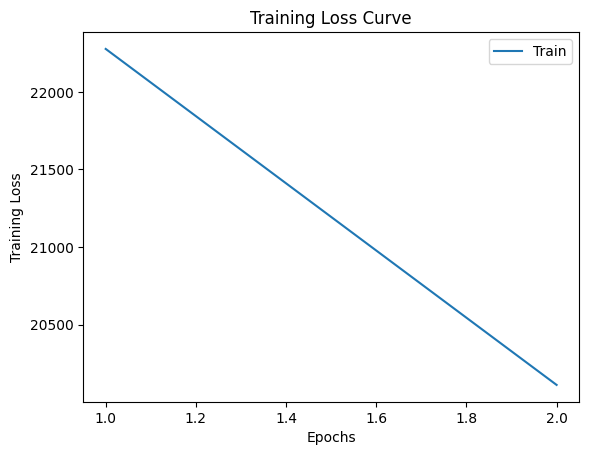

1 Final Training Loss: 20110.724935375845
Finished Training
Total time elapsed: 9.66 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

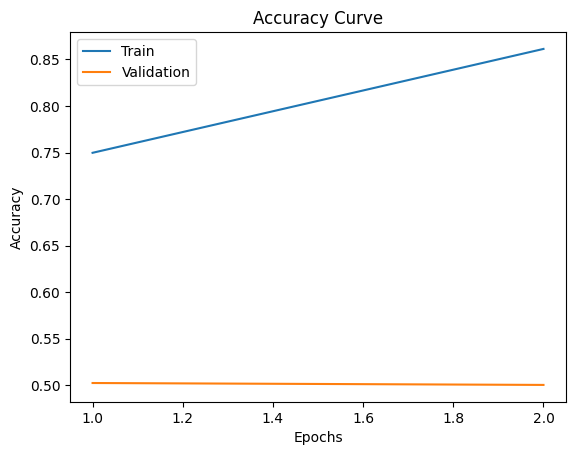

Final Training Accuracy: 0.861328125
Final Validation Accuracy: 0.50042793563848

Total time elapsed: 9.37 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb03\\chb03_04.edf'
 1 list([(553472, 566784)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb03\\chb03_04.edf'
 1 list([(553472, 566784)])]
Latency:  3.5
Sensitivity:  1.0
FPR:  151219.05482041588

Average latency: 3.5
Average sensitivity: 1.0
Average FPR: 151219.05482041588
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb03\\chb03_04.edf'
 1 list([(553472, 566784)])]
Speed:  160788.209931364

Average speed: 160788.209931364
Seizure speed test complete.



RUNNING ON CHB04

Executing under sampling
19895972
16584
Executing

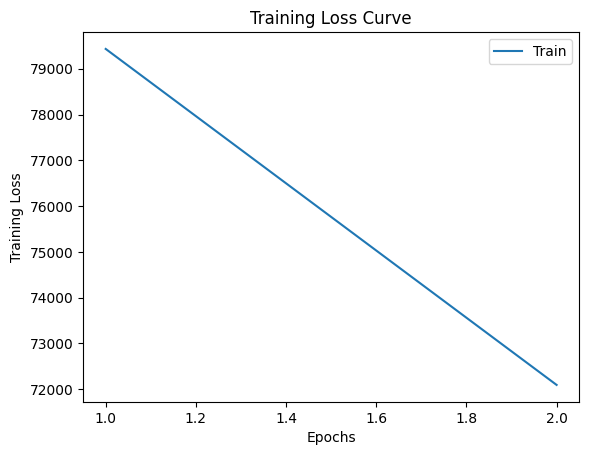

1 Final Training Loss: 72091.66674828231
Finished Training
Total time elapsed: 9.24 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

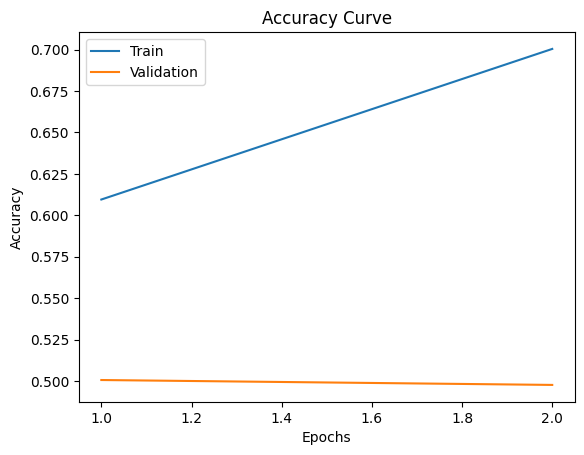

Final Training Accuracy: 0.7003738543174144
Final Validation Accuracy: 0.4976346433770015

Total time elapsed: 15.21 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb04\\chb04_05.edf'
 1 list([(1997824, 2010368)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb04\\chb04_05.edf'
 1 list([(1997824, 2010368)])]
Latency:  -1
Sensitivity:  0.0
FPR:  479731.95053849224

Average latency: -1
Average sensitivity: 0.0
Average FPR: 479731.95053849224
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb04\\chb04_05.edf'
 1 list([(1997824, 2010368)])]
Speed:  141607.43607974256

Average speed: 141607.43607974256
Seizure speed test complete.



RUNNING ON CHB05

Executing under sampling
446669

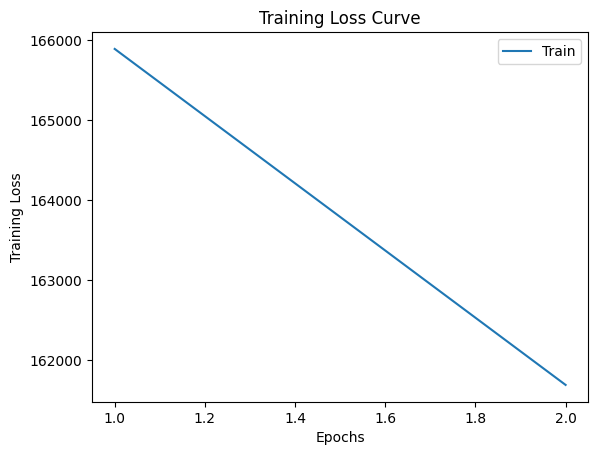

1 Final Training Loss: 161685.70549007808
Finished Training
Total time elapsed: 11.68 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43

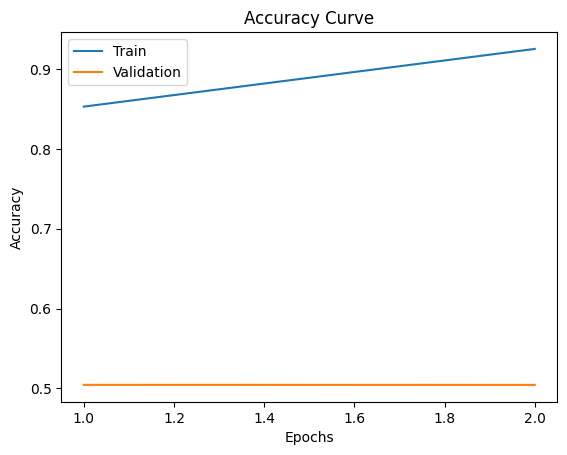

Final Training Accuracy: 0.9251776909777806
Final Validation Accuracy: 0.5043305040706738

Total time elapsed: 11.47 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb05\\chb05_06.edf'
 1 list([(106752, 136192)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb05\\chb05_06.edf'
 1 list([(106752, 136192)])]
Latency:  32.5
Sensitivity:  1.0
FPR:  91112.5383366408

Average latency: 32.5
Average sensitivity: 1.0
Average FPR: 91112.5383366408
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb05\\chb05_06.edf'
 1 list([(106752, 136192)])]
Speed:  161455.9978330136

Average speed: 161455.9978330136
Seizure speed test complete.



RUNNING ON CHB06

Executing under sampling
5436924
7222
E

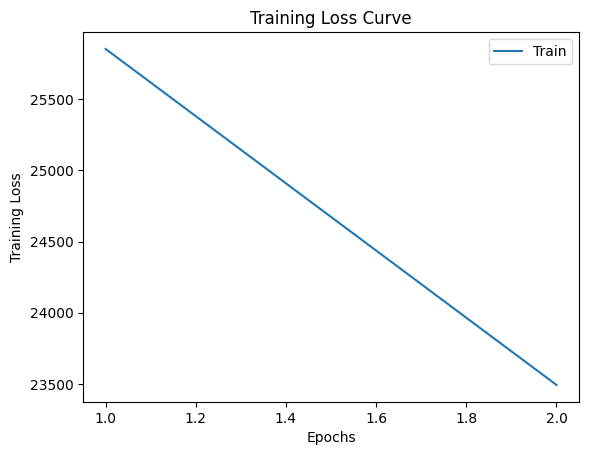

1 Final Training Loss: 23492.74537213081
Finished Training
Total time elapsed: 4.00 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

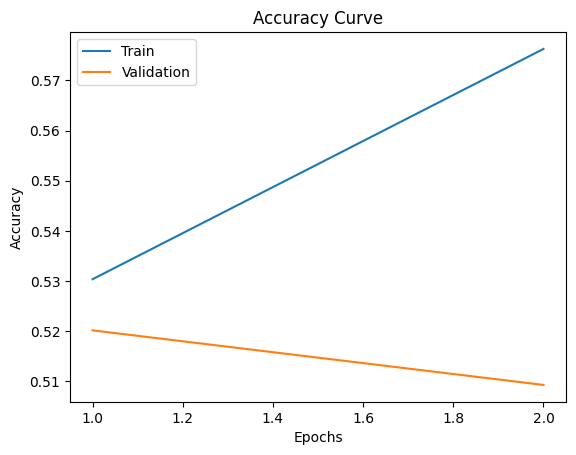

Final Training Accuracy: 0.5762651461154669
Final Validation Accuracy: 0.5093167701863354

Total time elapsed: 3.86 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb06\\chb06_04.edf'
 2 list([(83712, 88832), (1590016, 1595136)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb06\\chb06_04.edf'
 2 list([(83712, 88832), (1590016, 1595136)])]
Latency:  0.0
Sensitivity:  0.5
FPR:  347269.5652173913

Average latency: 0.0
Average sensitivity: 0.5
Average FPR: 347269.5652173913
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb06\\chb06_04.edf'
 2 list([(83712, 88832), (1590016, 1595136)])]
Speed:  150576.78443510592

Average speed: 150576.78443510592
Seizure speed test complete.



RU

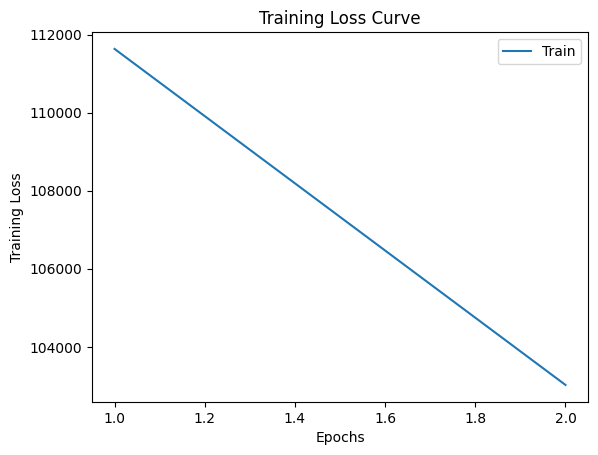

1 Final Training Loss: 103023.97669288942
Finished Training
Total time elapsed: 6.38 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

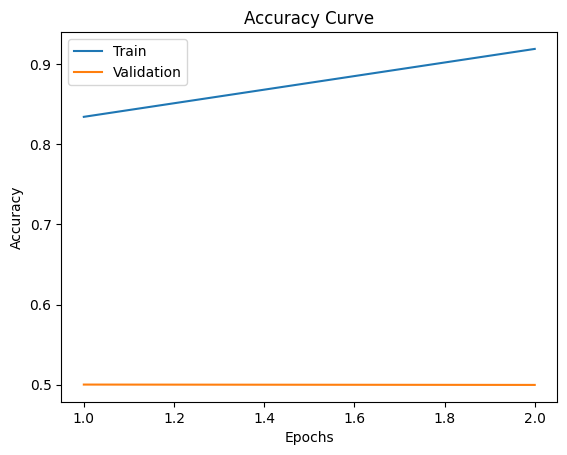

Final Training Accuracy: 0.9188260869565218
Final Validation Accuracy: 0.4997804128238911

Total time elapsed: 9.94 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb07\\chb07_12.edf'
 1 list([(1259520, 1281536)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb07\\chb07_12.edf'
 1 list([(1259520, 1281536)])]
Latency:  -1
Sensitivity:  0.0
FPR:  169693.5138987883

Average latency: -1
Average sensitivity: 0.0
Average FPR: 169693.5138987883
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb07\\chb07_12.edf'
 1 list([(1259520, 1281536)])]
Speed:  152520.95306302296

Average speed: 152520.95306302296
Seizure speed test complete.



RUNNING ON CHB08

Executing under sampling
1986050
3

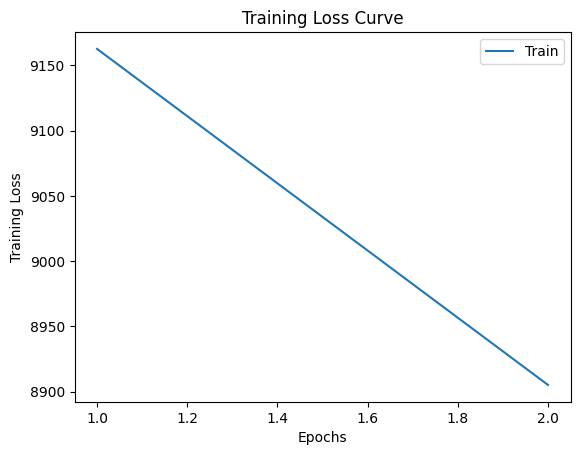

1 Final Training Loss: 8905.169788717269
Finished Training
Total time elapsed: 19.57 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

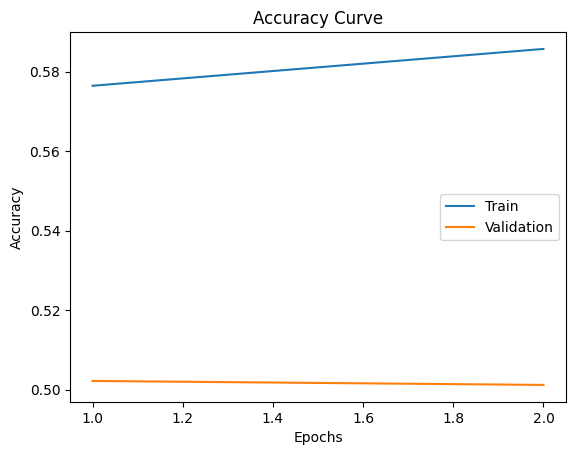

Final Training Accuracy: 0.5857126944640404
Final Validation Accuracy: 0.5012231735794507

Total time elapsed: 19.24 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb08\\chb08_13.edf'
 1 list([(618752, 659712)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb08\\chb08_13.edf'
 1 list([(618752, 659712)])]
Latency:  9.5
Sensitivity:  1.0
FPR:  213058.71535531327

Average latency: 9.5
Average sensitivity: 1.0
Average FPR: 213058.71535531327
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb08\\chb08_13.edf'
 1 list([(618752, 659712)])]
Speed:  162370.63730822183

Average speed: 162370.63730822183
Seizure speed test complete.



RUNNING ON CHB09

Executing under sampling
8018970
11

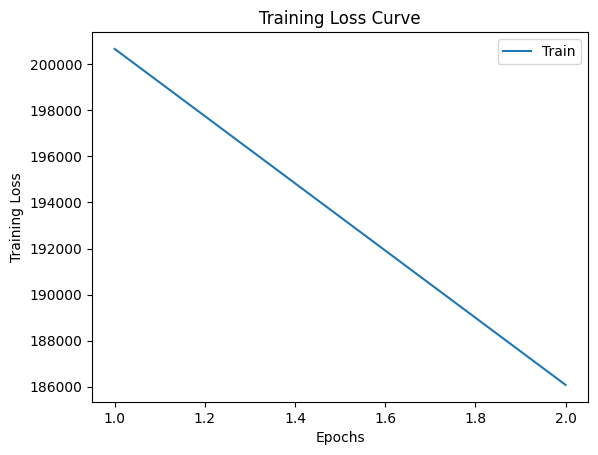

1 Final Training Loss: 186078.8469449964
Finished Training
Total time elapsed: 6.07 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

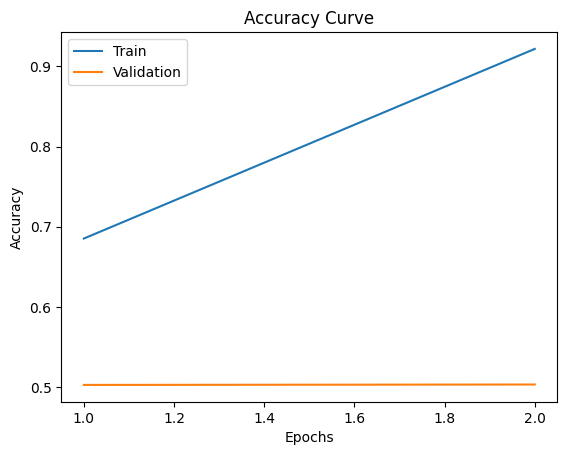

Final Training Accuracy: 0.9216829356471439
Final Validation Accuracy: 0.5032349896480331

Total time elapsed: 10.08 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb09\\chb09_19.edf'
 1 list([(1356544, 1372416)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb09\\chb09_19.edf'
 1 list([(1356544, 1372416)])]
Latency:  -1
Sensitivity:  0.0
FPR:  127431.1111111111

Average latency: -1
Average sensitivity: 0.0
Average FPR: 127431.1111111111
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb09\\chb09_19.edf'
 1 list([(1356544, 1372416)])]
Speed:  156488.0156674622

Average speed: 156488.0156674622
Seizure speed test complete.



RUNNING ON CHB10

Executing under sampling
4634224
19

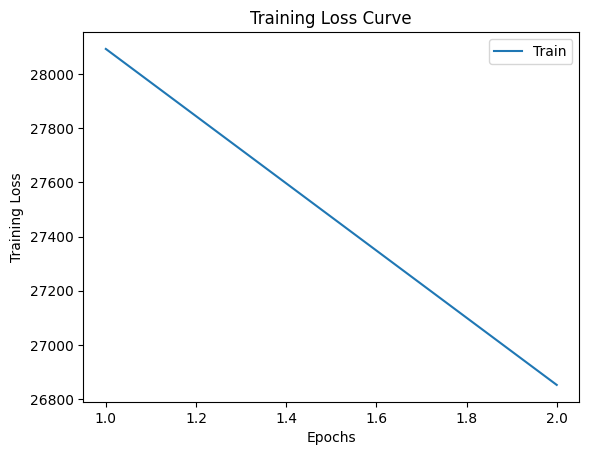

1 Final Training Loss: 26851.960710654344
Finished Training
Total time elapsed: 10.59 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43

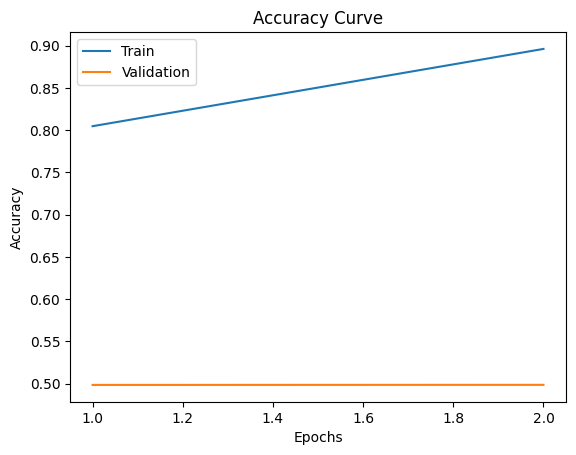

Streaming output truncated to the last 5000 lines.
Batch  573  complete.
Batch  574  complete.
Batch  575  complete.
Batch  576  complete.
Batch  577  complete.
Batch  578  complete.
Batch  579  complete.
Batch  580  complete.
Batch  581  complete.
Batch  582  complete.
Batch  583  complete.
Batch  584  complete.
Batch  585  complete.
Batch  586  complete.
Batch  587  complete.
Batch  588  complete.
Batch  589  complete.
Batch  590  complete.
Batch  591  complete.
Batch  592  complete.
Batch  593  complete.
Batch  594  complete.
Batch  595  complete.
Batch  596  complete.
Batch  597  complete.
Batch  598  complete.
Batch  599  complete.
Batch  600  complete.
Batch  601  complete.
Batch  602  complete.
Batch  603  complete.
Batch  604  complete.
Batch  605  complete.
Batch  606  complete.
Batch  607  complete.
Batch  608  complete.
Batch  609  complete.
Batch  610  complete.
Batch  611  complete.
Batch  612  complete.
Batch  613  complete.
Batch  614  complete.
Batch  615  complete.
Bat

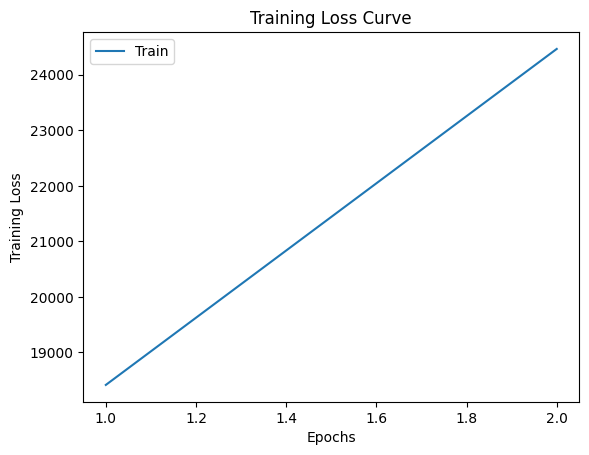

Streaming output truncated to the last 5000 lines.
Batch  573  complete.
Batch  574  complete.
Batch  575  complete.
Batch  576  complete.
Batch  577  complete.
Batch  578  complete.
Batch  579  complete.
Batch  580  complete.
Batch  581  complete.
Batch  582  complete.
Batch  583  complete.
Batch  584  complete.
Batch  585  complete.
Batch  586  complete.
Batch  587  complete.
Batch  588  complete.
Batch  589  complete.
Batch  590  complete.
Batch  591  complete.
Batch  592  complete.
Batch  593  complete.
Batch  594  complete.
Batch  595  complete.
Batch  596  complete.
Batch  597  complete.
Batch  598  complete.
Batch  599  complete.
Batch  600  complete.
Batch  601  complete.
Batch  602  complete.
Batch  603  complete.
Batch  604  complete.
Batch  605  complete.
Batch  606  complete.
Batch  607  complete.
Batch  608  complete.
Batch  609  complete.
Batch  610  complete.
Batch  611  complete.
Batch  612  complete.
Batch  613  complete.
Batch  614  complete.
Batch  615  complete.
Bat

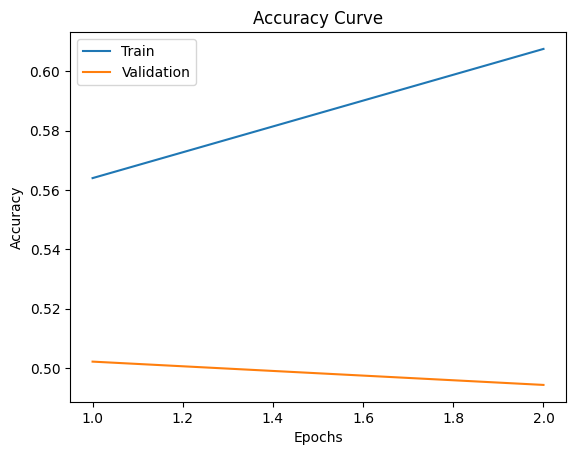

Streaming output truncated to the last 5000 lines.
Batch  4519  complete.
Batch  4520  complete.
Batch  4521  complete.
Batch  4522  complete.
Batch  4523  complete.
Batch  4524  complete.
Batch  4525  complete.
Batch  4526  complete.
Batch  4527  complete.
Batch  4528  complete.
Batch  4529  complete.
Batch  4530  complete.
Batch  4531  complete.
Batch  4532  complete.
Batch  4533  complete.
Batch  4534  complete.
Batch  4535  complete.
Batch  4536  complete.
Batch  4537  complete.
Batch  4538  complete.
Batch  4539  complete.
Batch  4540  complete.
Batch  4541  complete.
Batch  4542  complete.
Batch  4543  complete.
Batch  4544  complete.
Batch  4545  complete.
Batch  4546  complete.
Batch  4547  complete.
Batch  4548  complete.
Batch  4549  complete.
Batch  4550  complete.
Batch  4551  complete.
Batch  4552  complete.
Batch  4553  complete.
Batch  4554  complete.
Batch  4555  complete.
Batch  4556  complete.
Batch  4557  complete.
Batch  4558  complete.
Batch  4559  complete.
Batch 

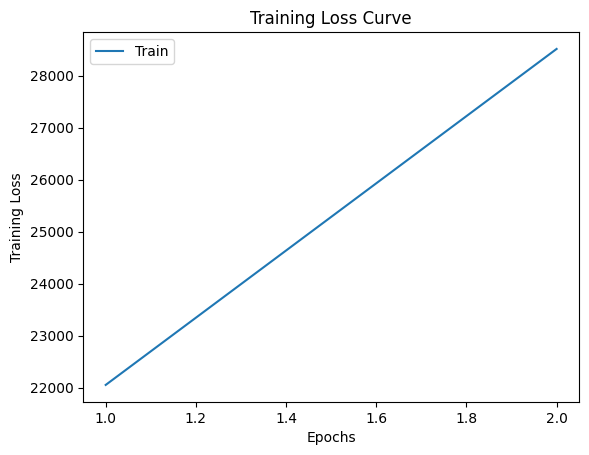

Streaming output truncated to the last 5000 lines.
Batch  1027  complete.
Batch  1028  complete.
Batch  1029  complete.
Batch  1030  complete.
Batch  1031  complete.
Batch  1032  complete.
Batch  1033  complete.
Batch  1034  complete.
Batch  1035  complete.
Batch  1036  complete.
Batch  1037  complete.
Batch  1038  complete.
Batch  1039  complete.
Batch  1040  complete.
Batch  1041  complete.
Batch  1042  complete.
Batch  1043  complete.
Batch  1044  complete.
Batch  1045  complete.
Batch  1046  complete.
Batch  1047  complete.
Batch  1048  complete.
Batch  1049  complete.
Batch  1050  complete.
Batch  1051  complete.
Batch  1052  complete.
Batch  1053  complete.
Batch  1054  complete.
Batch  1055  complete.
Batch  1056  complete.
Batch  1057  complete.
Batch  1058  complete.
Batch  1059  complete.
Batch  1060  complete.
Batch  1061  complete.
Batch  1062  complete.
Batch  1063  complete.
Batch  1064  complete.
Batch  1065  complete.
Batch  1066  complete.
Batch  1067  complete.
Batch 

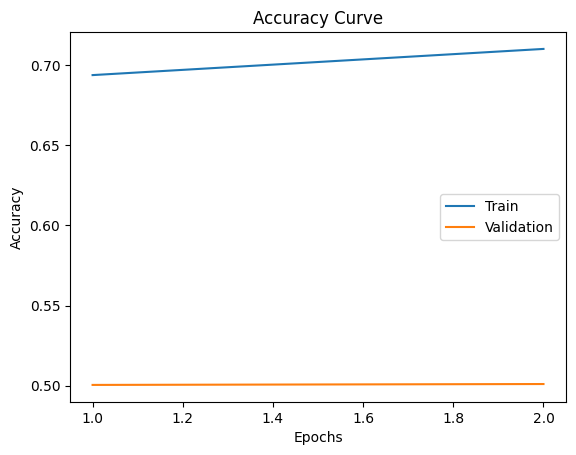

Final Training Accuracy: 0.7099902402558299
Final Validation Accuracy: 0.5010385331614382

Total time elapsed: 40.84 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb12\\chb12_38.edf'
 5
 list([(396288, 402688), (716288, 722176), (759296, 770304), (805376, 819456), (861184, 872960)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb12\\chb12_38.edf'
 5
 list([(396288, 402688), (716288, 722176), (759296, 770304), (805376, 819456), (861184, 872960)])]
Latency:  0.1
Sensitivity:  1.0
FPR:  465613.95020029845

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb12\\chb12_08.edf'
 4
 list([(365056, 368384), (407296, 413184), (500992, 506112), (716288, 722944)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-s

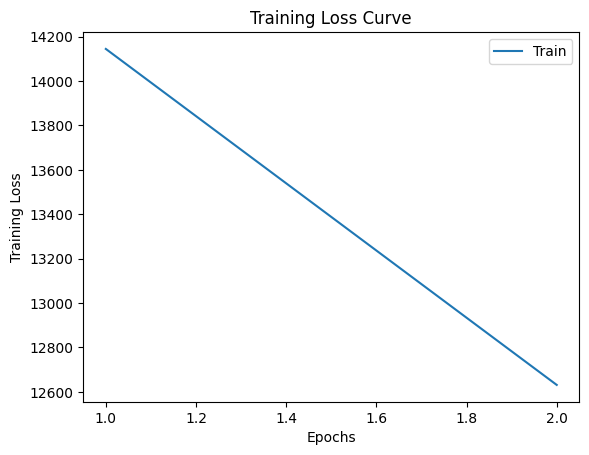

1 Final Training Loss: 12631.161568561583
Finished Training
Total time elapsed: 9.13 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

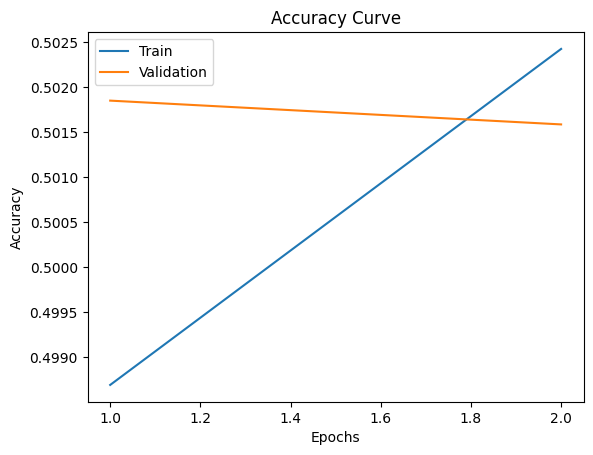

Final Training Accuracy: 0.5024268104776579
Final Validation Accuracy: 0.5015873015873016

Total time elapsed: 9.07 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_62.edf'
 3 list([(217856, 234496), (416256, 432896), (681984, 696576)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_62.edf'
 3 list([(217856, 234496), (416256, 432896), (681984, 696576)])]
Latency:  -1
Sensitivity:  0.0
FPR:  3558.3011583011585

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_21.edf'
 1 list([(239104, 257024)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb13\\chb13_21.edf'
 1 list([(239104, 257024)])]
Latency:  -1
Sensitivi

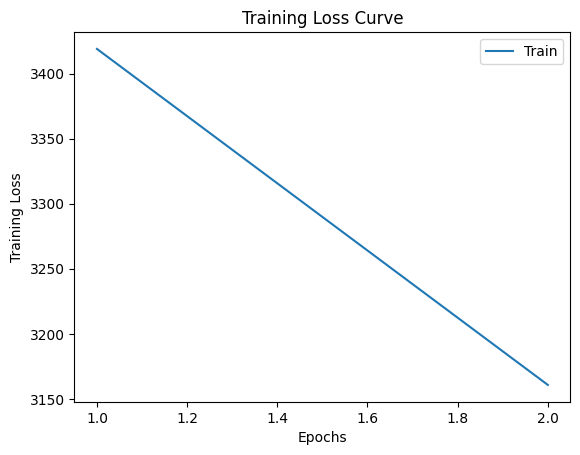

1 Final Training Loss: 3160.6847039023855
Finished Training
Total time elapsed: 5.78 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

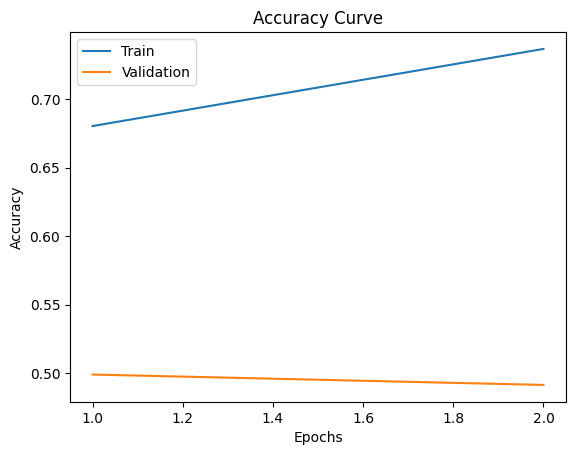

Streaming output truncated to the last 5000 lines.
Batch  1856  complete.
Batch  1857  complete.
Batch  1858  complete.
Batch  1859  complete.
Batch  1860  complete.
Batch  1861  complete.
Batch  1862  complete.
Batch  1863  complete.
Batch  1864  complete.
Batch  1865  complete.
Batch  1866  complete.
Batch  1867  complete.
Batch  1868  complete.
Batch  1869  complete.
Batch  1870  complete.
Batch  1871  complete.
Batch  1872  complete.
Batch  1873  complete.
Batch  1874  complete.
Batch  1875  complete.
Batch  1876  complete.
Batch  1877  complete.
Batch  1878  complete.
Batch  1879  complete.
Batch  1880  complete.
Batch  1881  complete.
Batch  1882  complete.
Batch  1883  complete.
Batch  1884  complete.
Batch  1885  complete.
Batch  1886  complete.
Batch  1887  complete.
Batch  1888  complete.
Batch  1889  complete.
Batch  1890  complete.
Batch  1891  complete.
Batch  1892  complete.
Batch  1893  complete.
Batch  1894  complete.
Batch  1895  complete.
Batch  1896  complete.
Batch 

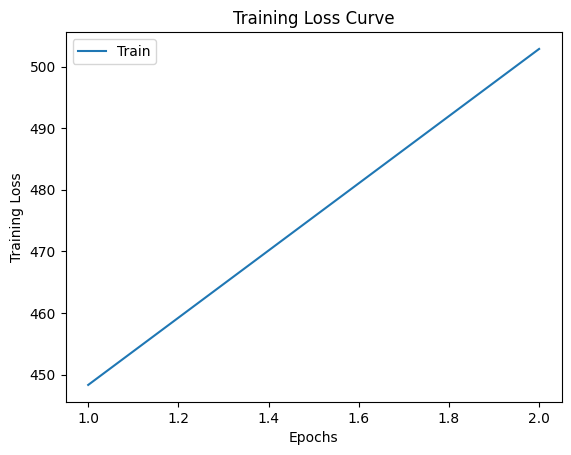

Streaming output truncated to the last 5000 lines.
Batch  3017  complete.
Batch  3018  complete.
Batch  3019  complete.
Batch  3020  complete.
Batch  3021  complete.
Batch  3022  complete.
Batch  3023  complete.
Batch  3024  complete.
Batch  3025  complete.
Batch  3026  complete.
Batch  3027  complete.
Batch  3028  complete.
Batch  3029  complete.
Batch  3030  complete.
Batch  3031  complete.
Batch  3032  complete.
Batch  3033  complete.
Batch  3034  complete.
Batch  3035  complete.
Batch  3036  complete.
Batch  3037  complete.
Batch  3038  complete.
Batch  3039  complete.
Batch  3040  complete.
Batch  3041  complete.
Batch  3042  complete.
Batch  3043  complete.
Batch  3044  complete.
Batch  3045  complete.
Batch  3046  complete.
Batch  3047  complete.
Batch  3048  complete.
Batch  3049  complete.
Batch  3050  complete.
Batch  3051  complete.
Batch  3052  complete.
Batch  3053  complete.
Batch  3054  complete.
Batch  3055  complete.
Batch  3056  complete.
Batch  3057  complete.
Batch 

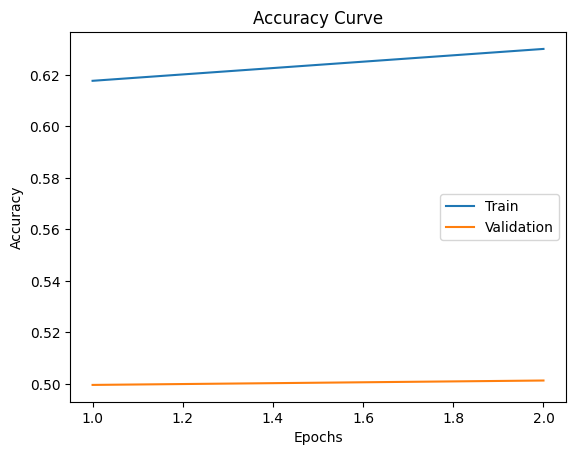

Final Training Accuracy: 0.6301429730910907
Final Validation Accuracy: 0.5012729906501031

Total time elapsed: 58.73 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_62.edf'
 1 list([(192256, 219904)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_62.edf'
 1 list([(192256, 219904)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  249043.54277764895

['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_46.edf'
 1 list([(850432, 877824)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb15\\chb15_46.edf'
 1 list([(850432, 877824)])]
Latency:  2.5
Sensitivity:  1.0
FPR:  300409.2631578947

['C:\\Users\\assaa\\Documents\\ECE4

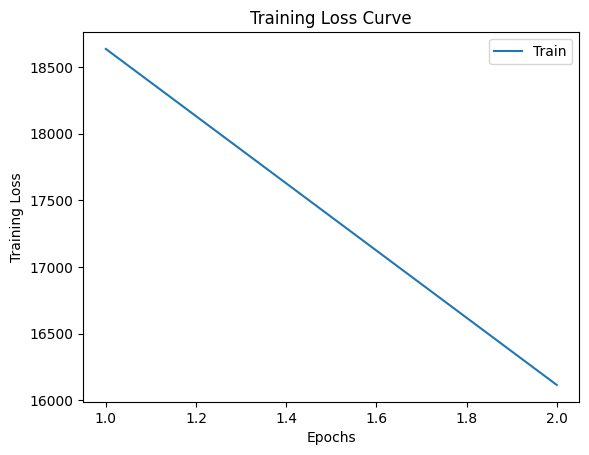

1 Final Training Loss: 16115.90612361407
Finished Training
Total time elapsed: 3.45 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

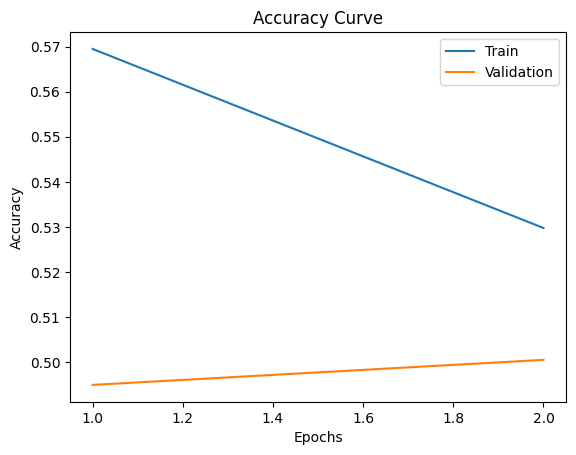

Final Training Accuracy: 0.5297619047619048
Final Validation Accuracy: 0.5005053908355795

Total time elapsed: 3.40 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb16\\chb16_18.edf'
 2 list([(160512, 162560), (488704, 490496)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb16\\chb16_18.edf'
 2 list([(160512, 162560), (488704, 490496)])]
Latency:  0.0
Sensitivity:  0.5
FPR:  907904.8951048951

Average latency: 0.0
Average sensitivity: 0.5
Average FPR: 907904.8951048951
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb16\\chb16_18.edf'
 2 list([(160512, 162560), (488704, 490496)])]
Speed:  154121.50102539125

Average speed: 154121.50102539125
Seizure speed test complete.



RU

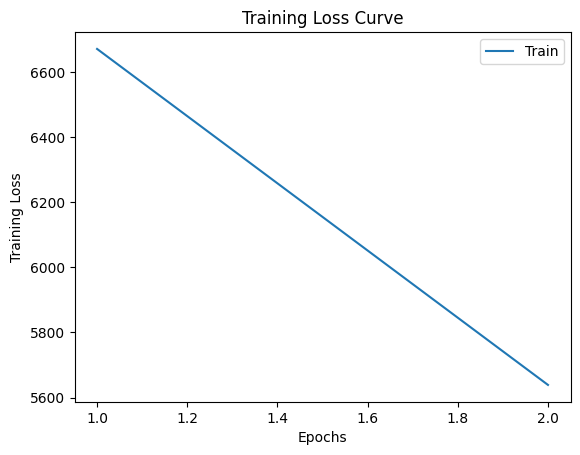

1 Final Training Loss: 5638.753266395039
Finished Training
Total time elapsed: 5.75 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

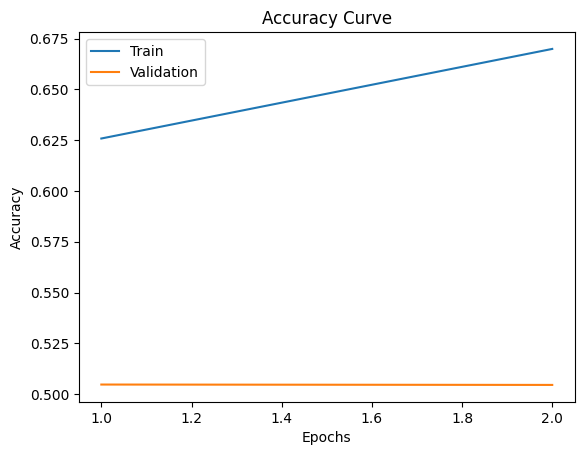

Final Training Accuracy: 0.669973544973545
Final Validation Accuracy: 0.5044876589379207

Total time elapsed: 8.52 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb17\\chb17a_04.edf'
 1 list([(774400, 803840)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb17\\chb17a_04.edf'
 1 list([(774400, 803840)])]
Latency:  -1
Sensitivity:  0.0
FPR:  106254.4161232958

Average latency: -1
Average sensitivity: 0.0
Average FPR: 106254.4161232958
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb17\\chb17a_04.edf'
 1 list([(774400, 803840)])]
Speed:  160995.9137443831

Average speed: 160995.9137443831
Seizure speed test complete.



RUNNING ON CHB18

Executing under sampling
4790356
17612
E

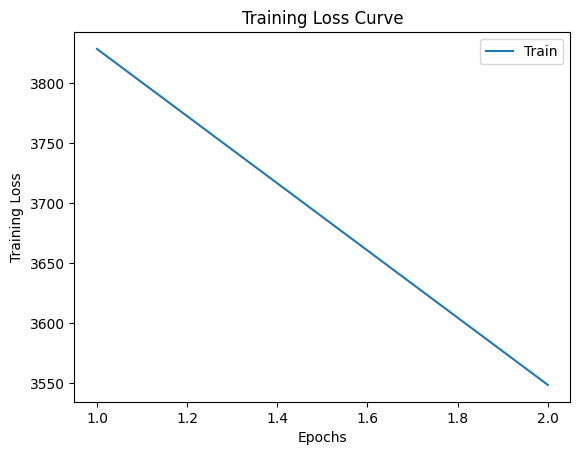

1 Final Training Loss: 3548.6693533222638
Finished Training
Total time elapsed: 9.61 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

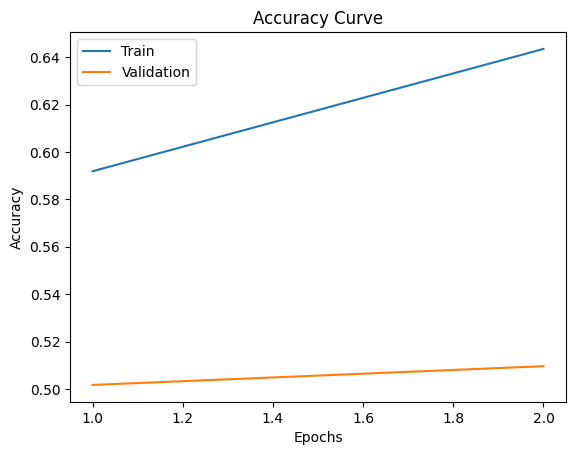

Final Training Accuracy: 0.6434499110847659
Final Validation Accuracy: 0.5095966958211856

Total time elapsed: 9.42 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb18\\chb18_30.edf'
 1 list([(138496, 146176)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb18\\chb18_30.edf'
 1 list([(138496, 146176)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  106623.74245472836

Average latency: 0.0
Average sensitivity: 1.0
Average FPR: 106623.74245472836
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb18\\chb18_30.edf'
 1 list([(138496, 146176)])]
Speed:  151934.02757520945

Average speed: 151934.02757520945
Seizure speed test complete.



RUNNING ON CHB19

Executing under sampling
4387120
929

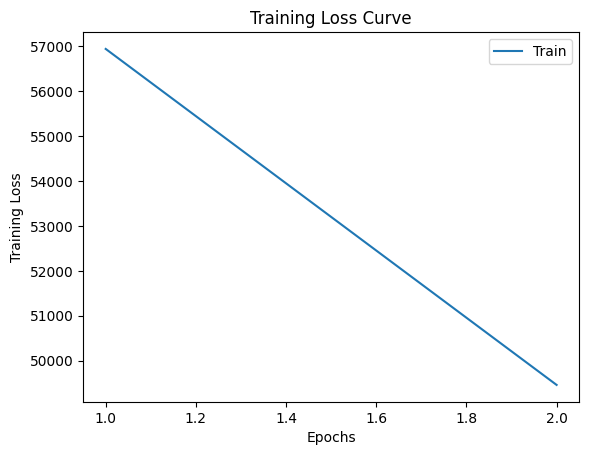

1 Final Training Loss: 49459.585088680615
Finished Training
Total time elapsed: 5.08 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

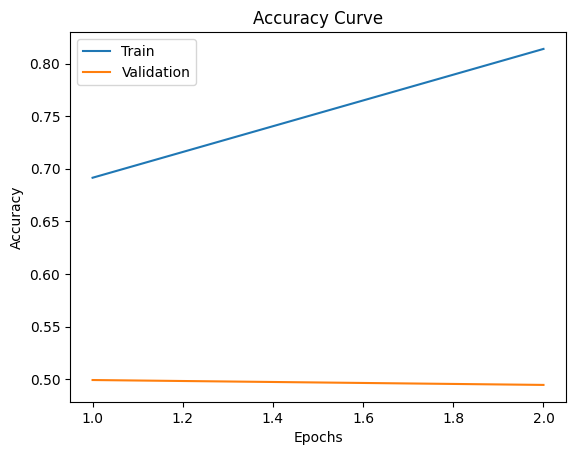

Final Training Accuracy: 0.8138984509466437
Final Validation Accuracy: 0.4945887445887446

Total time elapsed: 7.45 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb19\\chb19_30.edf'
 1 list([(808704, 829440)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb19\\chb19_30.edf'
 1 list([(808704, 829440)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  426553.9223781998

Average latency: 0.0
Average sensitivity: 1.0
Average FPR: 426553.9223781998
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb19\\chb19_30.edf'
 1 list([(808704, 829440)])]
Speed:  158438.98235160267

Average speed: 158438.98235160267
Seizure speed test complete.



RUNNING ON CHB20

Executing under sampling
3429104
16436

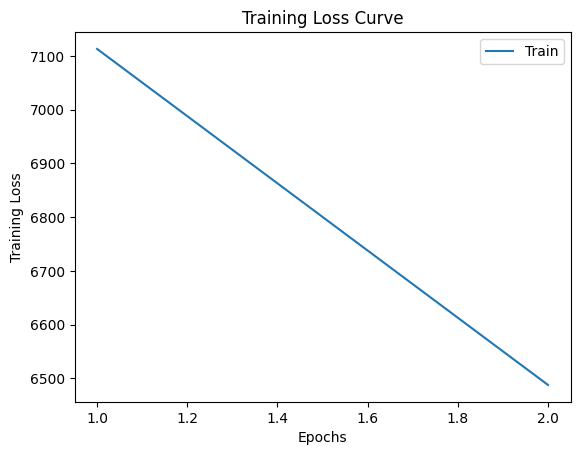

1 Final Training Loss: 6487.633879071544
Finished Training
Total time elapsed: 8.93 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

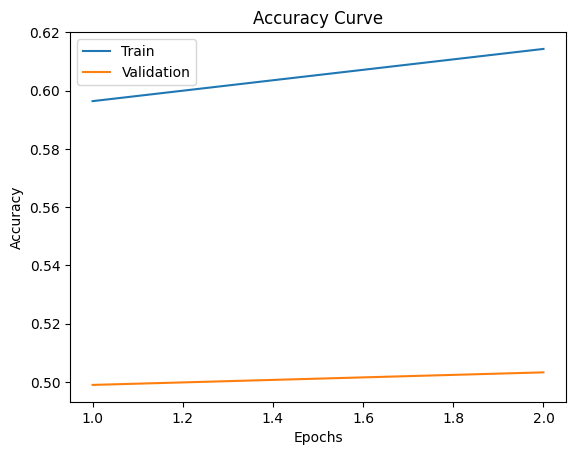

Final Training Accuracy: 0.6143214285714286
Final Validation Accuracy: 0.5032840722495895

Total time elapsed: 8.81 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb20\\chb20_68.edf'
 1 list([(356608, 366592)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb20\\chb20_68.edf'
 1 list([(356608, 366592)])]
Latency:  4.0
Sensitivity:  1.0
FPR:  377589.72712680575

Average latency: 4.0
Average sensitivity: 1.0
Average FPR: 377589.72712680575
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb20\\chb20_68.edf'
 1 list([(356608, 366592)])]
Speed:  158743.39736279935

Average speed: 158743.39736279935
Seizure speed test complete.



RUNNING ON CHB21

Executing under sampling
4631592
893

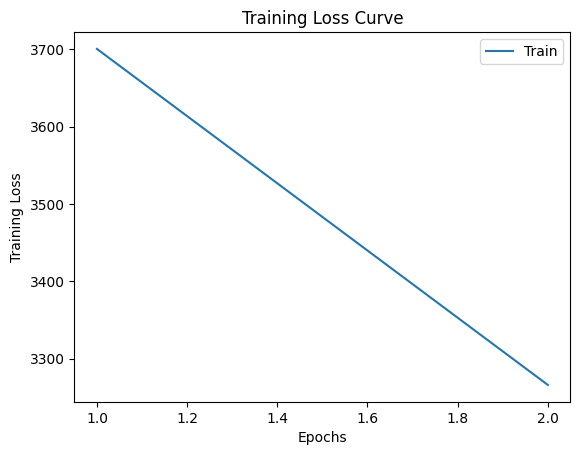

1 Final Training Loss: 3265.998556338397
Finished Training
Total time elapsed: 4.84 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

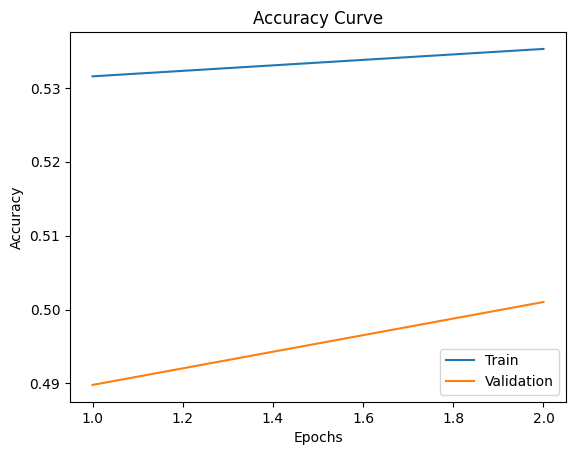

Final Training Accuracy: 0.5352741448692153
Final Validation Accuracy: 0.5010204081632653

Total time elapsed: 4.78 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb21\\chb21_19.edf'
 1 list([(329728, 344064)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb21\\chb21_19.edf'
 1 list([(329728, 344064)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  432702.43902439025

Average latency: 0.0
Average sensitivity: 1.0
Average FPR: 432702.43902439025
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb21\\chb21_19.edf'
 1 list([(329728, 344064)])]
Speed:  160143.14283068923

Average speed: 160143.14283068923
Seizure speed test complete.



RUNNING ON CHB22

Executing under sampling
4430888
800

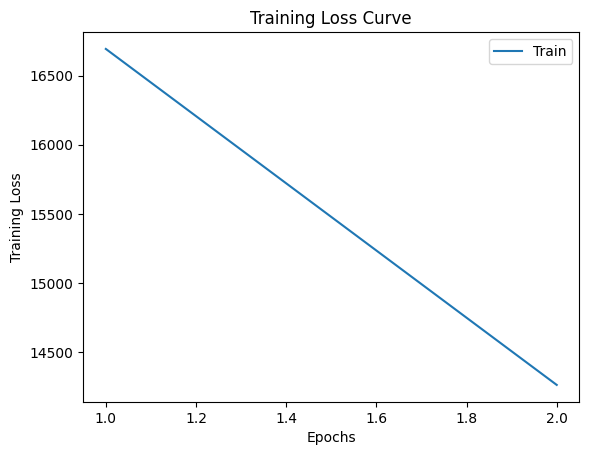

1 Final Training Loss: 14262.484557252683
Finished Training
Total time elapsed: 4.34 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43 

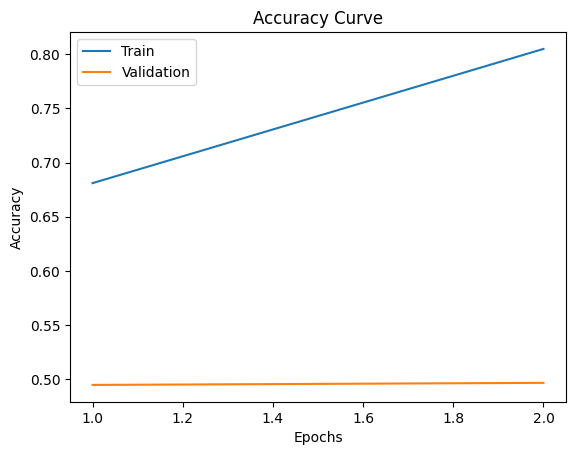

Final Training Accuracy: 0.8050074925074925
Final Validation Accuracy: 0.49663072776280326

Total time elapsed: 6.65 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb22\\chb22_38.edf'
 1 list([(323328, 341760)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb22\\chb22_38.edf'
 1 list([(323328, 341760)])]
Latency:  0.0
Sensitivity:  1.0
FPR:  441263.77880184335

Average latency: 0.0
Average sensitivity: 1.0
Average FPR: 441263.77880184335
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb22\\chb22_38.edf'
 1 list([(323328, 341760)])]
Speed:  157731.66340062785

Average speed: 157731.66340062785
Seizure speed test complete.



RUNNING ON CHB23

Executing under sampling
2683042
90

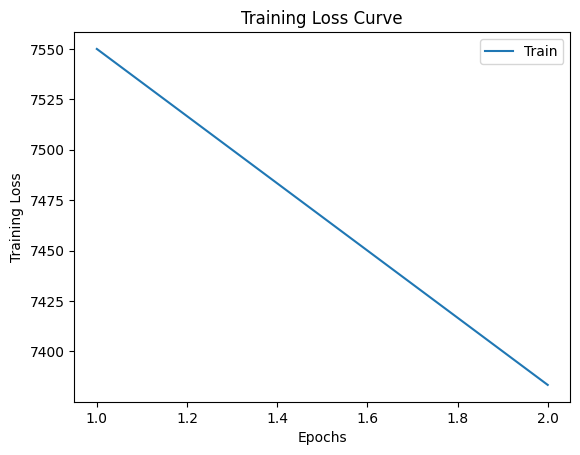

1 Final Training Loss: 7383.436166948977
Finished Training
Total time elapsed: 4.91 minutes
Initiating Fine-Tuning

Batch  1  complete.
Batch  2  complete.
Batch  3  complete.
Batch  4  complete.
Batch  5  complete.
Batch  6  complete.
Batch  7  complete.
Batch  8  complete.
Batch  9  complete.
Batch  10  complete.
Batch  11  complete.
Batch  12  complete.
Batch  13  complete.
Batch  14  complete.
Batch  15  complete.
Batch  16  complete.
Batch  17  complete.
Batch  18  complete.
Batch  19  complete.
Batch  20  complete.
Batch  21  complete.
Batch  22  complete.
Batch  23  complete.
Batch  24  complete.
Batch  25  complete.
Batch  26  complete.
Batch  27  complete.
Batch  28  complete.
Batch  29  complete.
Batch  30  complete.
Batch  31  complete.
Batch  32  complete.
Batch  33  complete.
Batch  34  complete.
Batch  35  complete.
Batch  36  complete.
Batch  37  complete.
Batch  38  complete.
Batch  39  complete.
Batch  40  complete.
Batch  41  complete.
Batch  42  complete.
Batch  43  

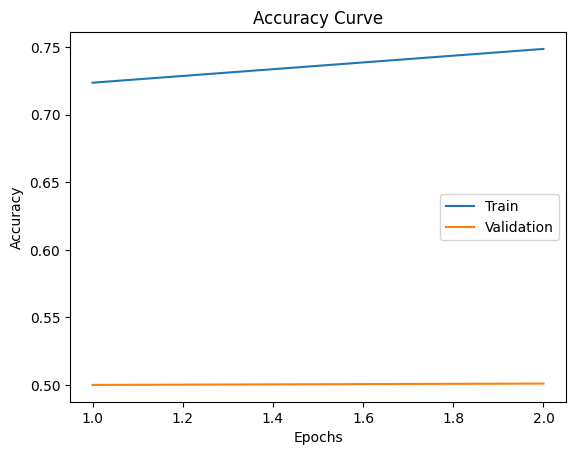

Final Training Accuracy: 0.7487000774421949
Final Validation Accuracy: 0.5010089891762979

Total time elapsed: 7.77 minutes

Training complete.
Running tests...


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb23\\chb23_09.edf'
 4
 list([(662784, 680960), (1762560, 1778432), (2177280, 2184192), (2452480, 2473984)])]
Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb23\\chb23_09.edf'
 4
 list([(662784, 680960), (1762560, 1778432), (2177280, 2184192), (2452480, 2473984)])]
Latency:  1.0
Sensitivity:  1.0
FPR:  359345.66851912386

Average latency: 1.0
Average sensitivity: 1.0
Average FPR: 359345.66851912386
Seizure accuracy test complete.


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb23\\chb23_09.edf'
 4
 list([(662784, 680960), (1762560, 1778432), (217728

In [ ]:
save_file = r'C:\Users\assaa\Documents\ECE496\Testing\test_results.txt'

for chb in range(1, 23):

  print(f"RUNNING ON CHB{chb+1:02}\n")
  
  #Split into train, validation, and test records. Seizure/non-seizure for
  #each.
  train_seizure_records, train_interictal_records, val_seizure_records, val_interictal_records, test_seizure_records, test_interictal_records = get_dataset_stats(chb+1)

  if len(val_seizure_records) != 0:
    train_seizure_records_plus_val = np.concatenate((train_seizure_records, val_seizure_records))
  else:
    train_seizure_records_plus_val = train_seizure_records
    val_seizure_records = np.array([train_seizure_records[0].tolist()])

  # train_plus_val_records = np.concatenate((train_records, val_records))

  train_interictal_records_plus_val = np.concatenate((train_interictal_records, val_interictal_records))


  #Training and validation data put together for the unsupervised stage.

  X_data = load_data(train_seizure_records_plus_val, True)
  # print(len(X_data))
  X_data += under_sample_new(train_interictal_records_plus_val, len(X_data))
  random.shuffle(X_data)
  X_data = np.asarray(X_data)
  X_train_all = X_data[:,0]



  #Training and validation data separated for the supervised stage.

  X_data = load_data(train_seizure_records, True)
  X_data += under_sample_new(train_interictal_records, len(X_data))
  random.shuffle(X_data)
  X_data = np.asarray(X_data)
  X_train = X_data[:,0]
  Y_train = X_data[:,1]

  X_data = load_data(val_seizure_records, True)
  X_data += under_sample_new(val_interictal_records, len(X_data))
  random.shuffle(X_data)
  X_data = np.asarray(X_data)
  X_val = X_data[:,0]
  Y_val = X_data[:,1]


  print("Initiating Pre-Training\n")
  autoencoder = StackedAutoencoder()
  autoencoder.cuda()

  train_net(autoencoder, chb+1, X_train_all, batch_size=32, learning_rate=0.01, num_epochs=2)

  #Save the weights and biases for the encoder layers, but not the decoder
  #layers.


  #Store the parameters of each layer in the stacked autoencoder.
  stacked_state = autoencoder.state_dict()

  #Initialize an empty ordered dictionary for the new classifier model.
  classifier_state = OrderedDict()

  #Loop through each encoder parameter and save it in the new dictionary.
  for param in stacked_state:
    if "encoder" in param:
      classifier_state[param] = stacked_state[param]


  #Load the previously freezed parameters into the new classifier model.

  #Create a new model and save its inital weights.
  classifier = Classifier()
  classifier_init_state = classifier.state_dict()

  #Replace the encoder weights with the ones acquired during training.
  for param in classifier_init_state:
    if param not in classifier_state:
      classifier_state[param] = classifier_init_state[param]

  #Save the new state in the classifier model.
  classifier.load_state_dict(classifier_state)

  # for param_name, param_val in classifier.named_parameters():
  #   if "encoder" in param_name:
  #     print(param_name)
  #     param_val.requires_grad = False

  # cnn_model = CNN()
  # classifier = Classifier()
  print("Initiating Fine-Tuning\n")
  classifier.cuda()
  train_classifier(classifier, chb+1, X_train, X_val, Y_train, Y_val, batch_size=32, learning_rate=0.01, num_epochs=2)

  # torch.save(classifier.state_dict(), fr"C:\Users\assaa\Documents\ECE496\Models\classifier_chb{chb+1:02}_32bs_2epochs_v2.pth")
  
  # classifier = Classifier()
  # classifier.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\classifier_chb01_32bs_2epochs_v2.pth"))

  print("\nTraining complete.")
  print("Running tests...\n\n")

  test_f = open(save_file, "a")
  test_f.write(f"\n\n\nTest results for CHB{chb+1:02}:\n\n")
  test_f.close()
  
  # test_f.write("Seizure Accuracy:\n")

  test_accuracy(classifier, test_seizure_records, save_file)
  print("Seizure accuracy test complete.\n\n")

  test_speed(classifier, test_seizure_records, save_file)
  print("Seizure speed test complete.\n\n\n")

In [ ]:
print(test_seizure_records)

In [ ]:
_, _, _, _, test_seizure_records, _ = get_dataset_stats(1)
test_seizure_records

C:\Users\assaa\AppData\Local\Temp\ipykernel_36032\2902924355.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(train_seizure_records), np.asarray(train_interictal_records), np.asarray(val_seizure_records), np.asarray(val_interictal_records), np.asarray(test_seizure_records), np.asarray(test_interictal_records)


array([['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf',
        1, list([(766976, 777216)])]], dtype=object)

In [ ]:
save_file = r'C:\Users\assaa\Documents\ECE496\Testing\OneFile\Autoencoder\test_results.txt'


classifier = Classifier()
classifier.load_state_dict(torch.load(r"C:\Users\assaa\Documents\ECE496\Models\Autoencoder\classifier_chb01_32bs_2epochs_v2.pth"))

test_f = open(save_file, "a")
test_f.write("Test results for CHB01_03:\n\n")
test_f.close()

test_accuracy(classifier, test_seizure_records, save_file, load_test_data_all)
print("Seizure accuracy test complete.\n\n")


['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]


C:\Users\assaa\AppData\Local\Temp\ipykernel_36032\920950842.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)
C:\Users\assaa\AppData\Local\Temp\ipykernel_36032\920950842.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2)


In [ ]:

test_speed(classifier, test_seizure_records, save_file, load_test_data_all)
print("Seizure speed test complete.\n\n\n")

C:\Users\assaa\AppData\Local\Temp\ipykernel_36032\3961537897.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.asarray(test_data)


Record:  ['C:\\Users\\assaa\\Documents\\ECE496\\Datasets\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb01\\chb01_03.edf'
 1 list([(766976, 777216)])]
Speed:  164948.12284969157

Average speed: 164948.12284969157
Seizure speed test complete.



